# Input Formatting

In [15]:
# Load necessary libraries
library(Signac)
library(Seurat)
library(GenomicRanges)
library(dplyr)

#----------------------#
# Configuration Setup #
#----------------------#

chosen_weeks = c(7, 9)
gender = 'male'

#----------------------#


# male sample time map
# Mapping from sample ID to developmental timepoint
male_sample_time_map <- list(
  FCA_GND9332157 = 17,
  FCA_GND8768487 = 12,
  FCA_GND8795928 = 12,
  FCA_GND8795927 = 7,
  FCA_GND8768482 = 9, 
  FCA_GND8768481 = 19,
  HD_F_GON9883958 = 21,
  HD_F_GON9479872 = 15
)

female_sample_time_map <- list(
  FCA_GND8046539 = 8.8,
  FCA_GND8768484 = 8.6,
  FCA_GND8768485 = 9
)


male_sample_paths <- list(
  FCA_GND8795927 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8795927/outs/",
  FCA_GND8768482 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8768482/outs/",
  FCA_GND8768485 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8768485/outs/",
  FCA_GND8795928 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8795928/outs/",
  FCA_GND9332157 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND9332157/outs/"
)

female_sample_paths <- list(
  FCA_GND8046539 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8046539/outs/",
  FCA_GND8768484 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768484/outs/",
  FCA_GND8768485 = "/group/tran3/gchahal/Garcia_et_all_FASTqs/female/FCAGND8768485/outs/"
)


#--------------------------------#
# Helper: Filter by timepoints   #
#--------------------------------#
filter_samples_by_weeks <- function(weeks, timemap) {
  selected <- names(Filter(function(w) w %in% weeks, timemap))
  return(selected)
}

#--------------------------------#
# Helper: Read & combine peaks   #
#--------------------------------#
# fix code here
read_and_process_peak_files <- function(sample_ids, sample_paths, min_threshold = 20, max_threshold = 10000) {
  cat("sample_ids inside function:", paste(sample_ids, collapse = ", "), "\n")
  cat("sample_paths inside function:", paste(sample_paths, collapse = ", "), "\n")
    
    
  gr_list <- lapply(sample_ids, function(id) {
    cat("sample_paths[[id]]:", paste(sample_paths[[id]], collapse = ", "), "\n")
      
    path <- paste0(sample_paths[[id]], "peaks.bed")
    cat("path:", paste(path, collapse = ", "), "\n")
      
    if (!file.exists(path)) return(NULL)
    peaks <- read.table(path, col.names = c("chr", "start", "end"))
    
    makeGRangesFromDataFrame(peaks)
  })
  combined.peaks <- reduce(do.call(c, gr_list))
  combined.peaks <- combined.peaks[width(combined.peaks) > min_threshold & width(combined.peaks) < max_threshold]

  combined.peaks <- combined.peaks[!grepl("^KI", seqnames(combined.peaks))]
  combined.peaks <- combined.peaks[!grepl("^GL", seqnames(combined.peaks))]
  combined.peaks

  return(combined.peaks)
}

#------------------------------#
# Build Seurat Object per ID  #
#------------------------------#
create_seurat_obj <- function(sample_id, combined_peaks, sample_paths) {
  path <- sample_paths[[sample_id]]
  cat("path:", path, "\n")
  
  md <- read.table(
    file = paste0(path, "singlecell.csv"),
    stringsAsFactors = FALSE, sep = ",", header = TRUE, row.names = 1
  )[-1, ]
  md <- md[md$passed_filters > 500, ]
  cat("metadata shape:", dim(md), "\n")  # rows = cells, cols = metadata fields
  
  frags <- CreateFragmentObject(path = paste0(path, "fragments.tsv.gz"), cells = rownames(md))
  
  counts <- FeatureMatrix(fragments = frags, features = combined_peaks, cells = rownames(md))
  cat("counts shape:", dim(counts), "\n")  # rows = peaks, cols = cells
  
  chrom_assay <- CreateChromatinAssay(counts, fragments = frags)
  obj <- CreateSeuratObject(chrom_assay, assay = "ATAC", meta.data = md)
  obj$dataset <- sample_id
  cat("Seurat object shape:", dim(obj), "\n")  # rows = peaks, cols = cells
  
  return(obj)
}

#------------------------------#
# Add cell type annotations   #
#------------------------------#
annotate_cells <- function(seurat_obj, sample_id, annot_file = "/group/tran3/gchahal/Garcia_et_all_FASTqs/atac_metadata.csv") {
  cat(paste(rep("*", 100), collapse = ""), "\n")

  # 1. Read and preprocess annotation file
  annotations <- read.table(annot_file, header = TRUE, sep = ',')
  cat("[INFO] Loaded annotations:", nrow(annotations), "rows\n")
  annotations$X <- sub("^\\d{2}-", "", annotations$X)

  # 2. Filter for current sample
  subset_ann <- subset(annotations, sample == sample_id)
  cat("[INFO] Annotations for", sample_id, ":", nrow(subset_ann), "rows\n")

  # 3. Prepare annotation vector
  cell_ids <- colnames(seurat_obj)
  cat("[INFO] Seurat object contains", length(cell_ids), "cells\n")

  cell_type_vector <- setNames(rep("missing", length(cell_ids)), cell_ids)
  matched_ids <- subset_ann$X %in% cell_ids
  matched_cells <- subset_ann$X[matched_ids]
  matched_types <- subset_ann$cell_type[matched_ids]

  cat("[INFO] Matching annotation rows:", sum(matched_ids), "\n")
  cell_type_vector[matched_cells] <- matched_types

  # 4. Add metadata
  seurat_obj <- AddMetaData(seurat_obj, metadata = cell_type_vector, col.name = "cell_type")

  # 5. Print sorted cell type frequency
  cat("\n[INFO] Cell type frequency (sorted):\n")
  print(sort(table(seurat_obj$cell_type), decreasing = TRUE))

  # 6. Check fragment object
  cat("\n[INFO] Fragment object:\n")
  print(Fragments(seurat_obj)[[1]])

  # 7. Check ATAC count matrix dimensions
  cat("\n[INFO] ATAC count matrix dimensions:\n")
  print(dim(GetAssayData(seurat_obj, assay = "ATAC", slot = "counts")))

  # 8. Check for empty metadata columns
  meta <- seurat_obj@meta.data
  empty_cols <- sapply(meta, function(x) all(is.na(x) | x == ""))
  if (any(empty_cols)) {
    cat("\n[WARNING] Empty metadata columns:\n")
    print(names(meta)[empty_cols])
  } else {
    cat("\n[INFO] No empty metadata columns found.\n")
  }

  # 9. Print Seurat object
  cat("\n[INFO] Final Seurat object summary:\n")
  print(seurat_obj)

  cat(paste(rep("*", 10), collapse = ""), "\n")

  return(seurat_obj)
}


#------------------------------#
# Full Pipeline Function      #
#------------------------------#
process_atac_pipeline <- function(weeks, timemap, sample_paths) {
  sample_ids <- filter_samples_by_weeks(weeks, timemap)
  cat("sample_ids:", paste(sample_ids, collapse = ", "), "\n")
  cat("sample_paths:", paste(sample_paths, collapse = ", "), "\n")
    
  combined_peaks <- read_and_process_peak_files(sample_ids, sample_paths)
  cat("Combined peaks:\n")
  print(combined_peaks)

  cat("seqlevels peaks:\n")
  seqlevels(combined_peaks)

  
  objs <- list()
  for (id in sample_ids) {
    cat("\nProcessing:", id, "\n")
    
    obj <- create_seurat_obj(id, combined_peaks, sample_paths)
    cat("Created Seurat object:\n")
    print(obj)
    
    obj <- annotate_cells(obj, id)
    cat("Annotated Seurat object:\n")
    print(obj)
    
    objs[[id]] <- obj
  }

  cat("Merging Seurat objects...\n")
  merged <- Reduce(function(x, y) merge(x, y, add.cell.ids = c(x$dataset[1], y$dataset[1])), objs)
  cat("Final merged object:\n")
  print(merged)

  return(merged)
}


# Load required packages
library(Signac)
library(Seurat)
library(GenomicRanges)
library(data.table)

# Run the pipeline
# if gender == 'female', proceed this otherwise, proceed for male 
# combined_ovary <- process_atac_pipeline(weeks = chosen_weeks,
#                                         timemap = female_sample_time_map,
#                                         sample_paths = female_sample_paths)

if (gender == "female") {
  combined_ovary <- process_atac_pipeline(
    weeks = chosen_weeks,
    timemap = female_sample_time_map,
    sample_paths = female_sample_paths
  )
  combined <- combined_ovary
} else if (gender == "male") {
  combined_testis <- process_atac_pipeline(
    weeks = chosen_weeks,
    timemap = male_sample_time_map,
    sample_paths = male_sample_paths
  )
  combined <- combined_testis
} else {
  stop("Invalid gender. Must be 'male' or 'female'.")
}




Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:GenomicRanges':

    shift


The following object is masked from 'package:IRanges':

    shift


The following objects are masked from 'package:S4Vectors':

    first, second




sample_ids: FCA_GND8795927, FCA_GND8768482 
sample_paths: /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8795927/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8768482/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8768485/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8795928/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND9332157/outs/ 
sample_ids inside function: FCA_GND8795927, FCA_GND8768482 
sample_paths inside function: /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8795927/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8768482/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8768485/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8795928/outs/, /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND9332157/outs/ 
sample_paths[[id]]: /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8795927/outs/ 
path: /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8795927/outs/peaks.bed 
s

Computing hash

Extracting reads overlapping genomic regions



counts shape: 195095 17313 
Seurat object shape: 195095 17313 
Created Seurat object:
An object of class Seurat 
195095 features across 17313 samples within 1 assay 
Active assay: ATAC (195095 features, 0 variable features)
 2 layers present: counts, data
**************************************************************************************************** 
[INFO] Loaded annotations: 136916 rows
[INFO] Annotations for FCA_GND8795927 : 7486 rows
[INFO] Seurat object contains 17313 cells
[INFO] Matching annotation rows: 7486 

[INFO] Cell type frequency (sorted):

          missing            Neural  Mesenchymal_LHX9        Supporting 
             9827              2741              1708               688 
       Epithelial         Erythroid           Sertoli       Endothelial 
              550               427               424               305 
      FetalLeydig            Immune Mesenchymal_GATA2           CoelEpi 
              252               235               112               

Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead."


[1] 195095  17313

[INFO] No empty metadata columns found.

[INFO] Final Seurat object summary:
An object of class Seurat 
195095 features across 17313 samples within 1 assay 
Active assay: ATAC (195095 features, 0 variable features)
 2 layers present: counts, data
********** 
Annotated Seurat object:
An object of class Seurat 
195095 features across 17313 samples within 1 assay 
Active assay: ATAC (195095 features, 0 variable features)
 2 layers present: counts, data

Processing: FCA_GND8768482 
path: /group/tran3/gchahal/Garcia_et_all_FASTqs/male/FCAGND8768482/outs/ 
metadata shape: 3862 18 


Computing hash

Extracting reads overlapping genomic regions



counts shape: 195095 3862 
Seurat object shape: 195095 3862 
Created Seurat object:
An object of class Seurat 
195095 features across 3862 samples within 1 assay 
Active assay: ATAC (195095 features, 0 variable features)
 2 layers present: counts, data
**************************************************************************************************** 
[INFO] Loaded annotations: 136916 rows
[INFO] Annotations for FCA_GND8768482 : 2847 rows
[INFO] Seurat object contains 3862 cells
[INFO] Matching annotation rows: 2847 

[INFO] Cell type frequency (sorted):

Mesenchymal_GATA2           missing           Sertoli  Mesenchymal_LHX9 
             1335              1015               581               355 
      Endothelial        Supporting            Immune                PV 
              164               127                92                56 
        Erythroid        Epithelial       FetalLeydig           CoelEpi 
               50                42                26                11 

In [16]:
# library(Signac)
# library(GenomicRanges)
library(Seurat)
library(dplyr)


In [17]:
combined

An object of class Seurat 
195095 features across 21175 samples within 1 assay 
Active assay: ATAC (195095 features, 0 variable features)
 2 layers present: counts, data

# QC Filtering

In [18]:
pbmc = combined
# peaks not found in this seurat object
pbmc[['ATAC']]
# granges(pbmc)

peaks.keep <- seqnames(granges(pbmc)) %in% standardChromosomes(granges(pbmc))
pbmc <- pbmc[as.vector(peaks.keep), ]

library(AnnotationHub)
ah <- AnnotationHub()

# Search for the Ensembl 98 EnsDb for Homo sapiens on AnnotationHub
query(ah, "EnsDb.Hsapiens.v98")

ensdb_v98 <- ah[["AH75011"]]
# # extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = ensdb_v98)

# change to UCSC style since the data was mapped to hg38
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg38"
# add the gene information to the object
Annotation(pbmc) <- annotations
pbmc

ChromatinAssay data with 195095 features for 21175 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 2 

AnnotationHub with 1 record
# snapshotDate(): 2024-10-28
# names(): AH75011
# $dataprovider: Ensembl
# $species: Homo sapiens
# $rdataclass: EnsDb
# $rdatadateadded: 2019-05-02
# $title: Ensembl 98 EnsDb for Homo sapiens
# $description: Gene and protein annotations for Homo sapiens based on Ensem...
# $taxonomyid: 9606
# $genome: GRCh38
# $sourcetype: ensembl
# $sourceurl: http://www.ensembl.org
# $sourcesize: NA
# $tags: c("98", "AHEnsDbs", "Annotation", "EnsDb", "Ensembl", "Gene",
#   "Protein", "Transcript") 
# retrieve record with 'object[["AH75011"]]' 

loading from cache

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress 

An object of class Seurat 
195095 features across 21175 samples within 1 assay 
Active assay: ATAC (195095 features, 0 variable features)
 2 layers present: counts, data

In [19]:
# compute nucleosome signal score per cell
pbmc <- NucleosomeSignal(object = pbmc)

# compute TSS enrichment score per cell
pbmc <- TSSEnrichment(object = pbmc)


Extracting TSS positions

Extracting fragments at TSSs

Warning message in cc + as.vector(x = counts.center):
"longer object length is not a multiple of shorter object length"
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
"number of items to replace is not a multiple of replacement length"
Warning message in fc + as.vector(x = counts.flank):
"longer object length is not a multiple of shorter object length"
Warning message in fc[names(x = counts.flank)] <- fc + as.vector(x = counts.flank):
"number of items to replace is not a multiple of replacement length"
Warning message in cc + as.vector(x = counts.center):
"longer object length is not a multiple of shorter object length"
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
"number of items to replace is not a multiple of replacement length"
Warning message in fc + as.vector(x = counts.flank):
"longer object length is not a multiple of shorter object length"
War

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,⋯,peak_region_cutsites,dataset,cell_type,nonprimary,excluded_reason,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,pct_reads_in_peaks
,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCA_GND8795927_AAACGAAAGCAATAAC-1,SeuratProject,8198,7444,52256,8209,697,301,5811,613,36625,⋯,11947,FCA_GND8795927,Neural,NA,NA,0.7177173,0.70,3.404967,0.33,17.5727
FCA_GND8795927_AAACGAAAGCATACCT-1,SeuratProject,108,105,1195,236,20,10,186,5,738,⋯,142,FCA_GND8795927,missing,NA,NA,0.4282407,0.07,2.730603,0.24,10.2981
FCA_GND8795927_AAACGAAAGGTTCGAG-1,SeuratProject,5461,4994,15272,3213,151,97,1061,656,10094,⋯,9518,FCA_GND8795927,Supporting,NA,NA,0.6868375,0.64,3.999449,0.53,49.2768


An object of class Seurat 
195095 features across 21175 samples within 1 assay 
Active assay: ATAC (195095 features, 0 variable features)
 2 layers present: counts, data

Warning message:
"Removed 162 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`)."


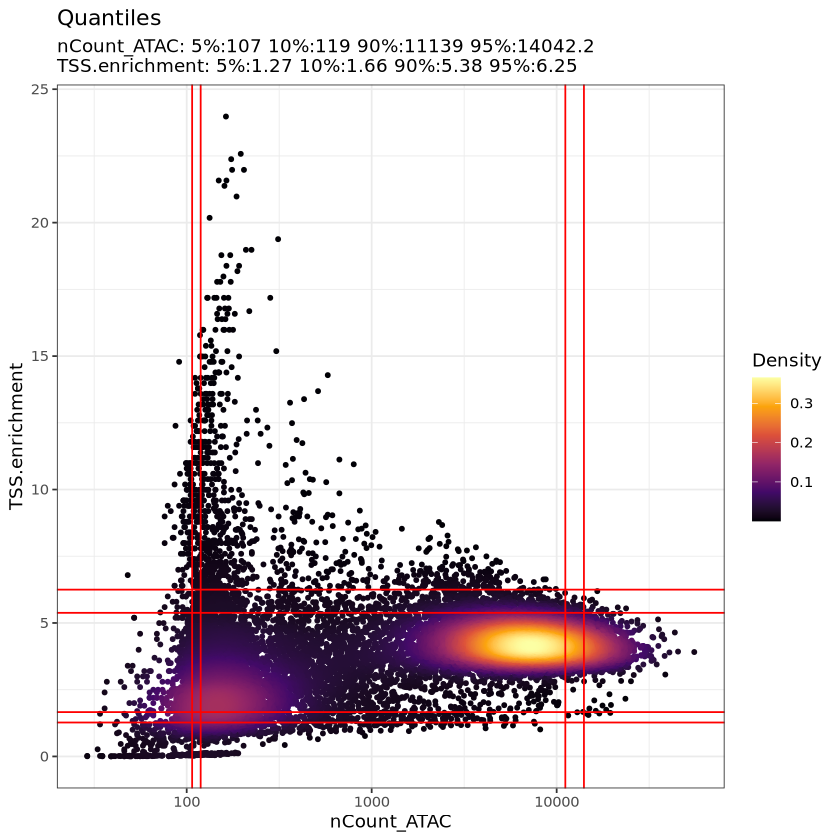

Warning message:
"The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Warning message:
"`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."


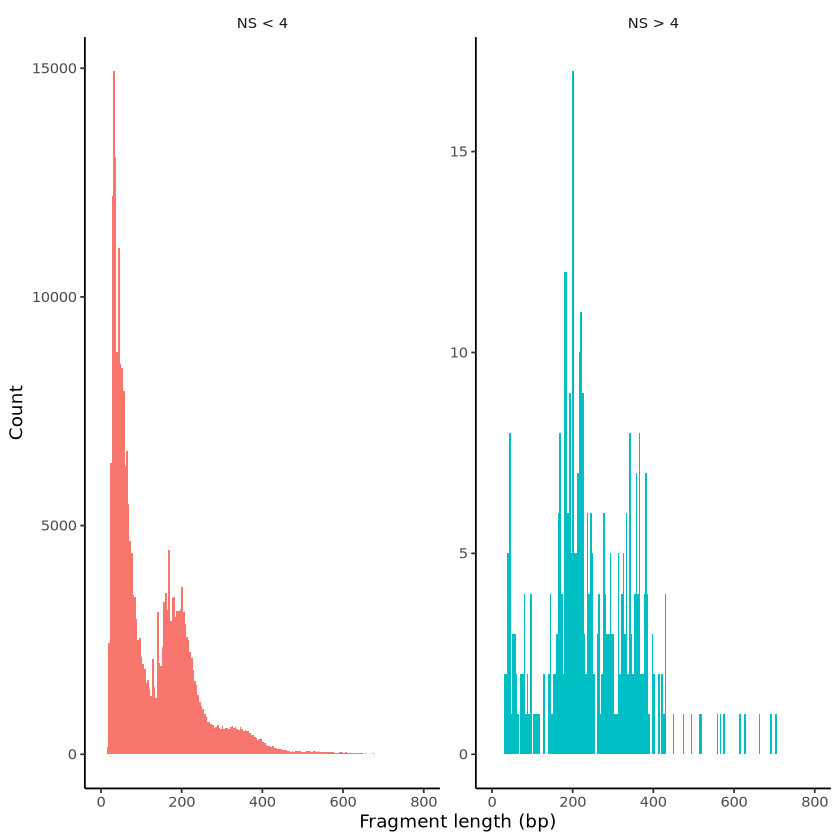

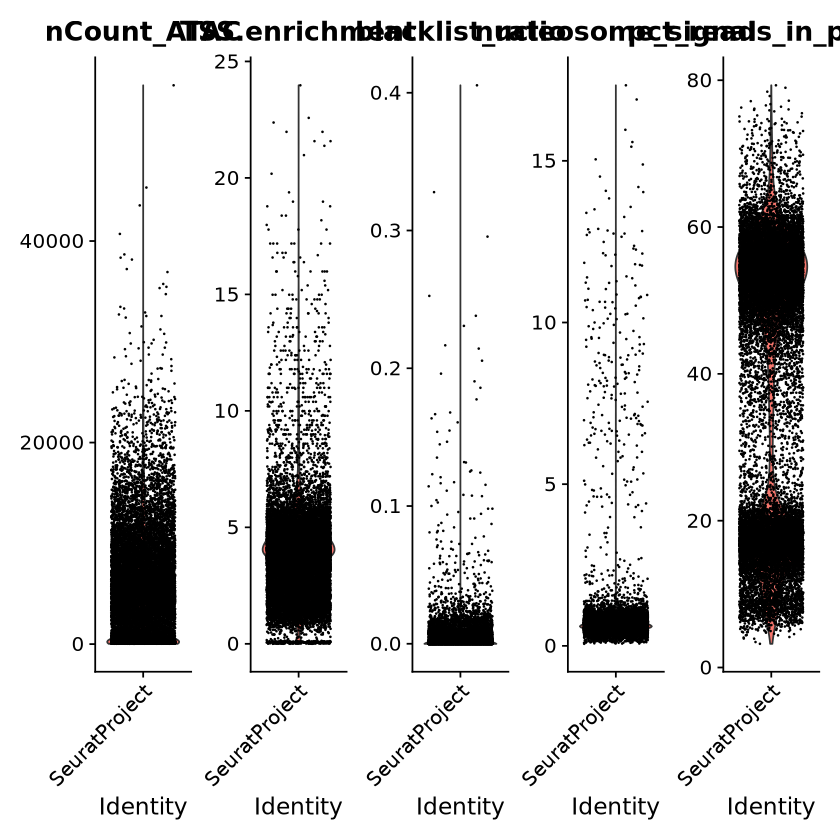

In [20]:

# add fraction of reads in peaks
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100

head(pbmc,3)

# add blacklist ratio
pbmc$blacklist_ratio <- FractionCountsInRegion(
  object = pbmc, 
  assay = 'ATAC',
  regions = blacklist_hg38_unified
)

DensityScatter(pbmc, x = 'nCount_ATAC', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

pbmc

pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')



VlnPlot(
  object = pbmc,
  features = c('nCount_ATAC', 'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 5
)



In [21]:
# filtering
pbmc <- subset(
  x = pbmc,
  subset = nCount_ATAC > 9000 &
    nCount_ATAC < 100000 &
    pct_reads_in_peaks > 40 &
    blacklist_ratio < 0.01 &
    nucleosome_signal < 4 &
    TSS.enrichment > 4
)
pbmc

An object of class Seurat 
195095 features across 2031 samples within 1 assay 
Active assay: ATAC (195095 features, 0 variable features)
 2 layers present: counts, data

Warning message:
"Removed 29 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`)."


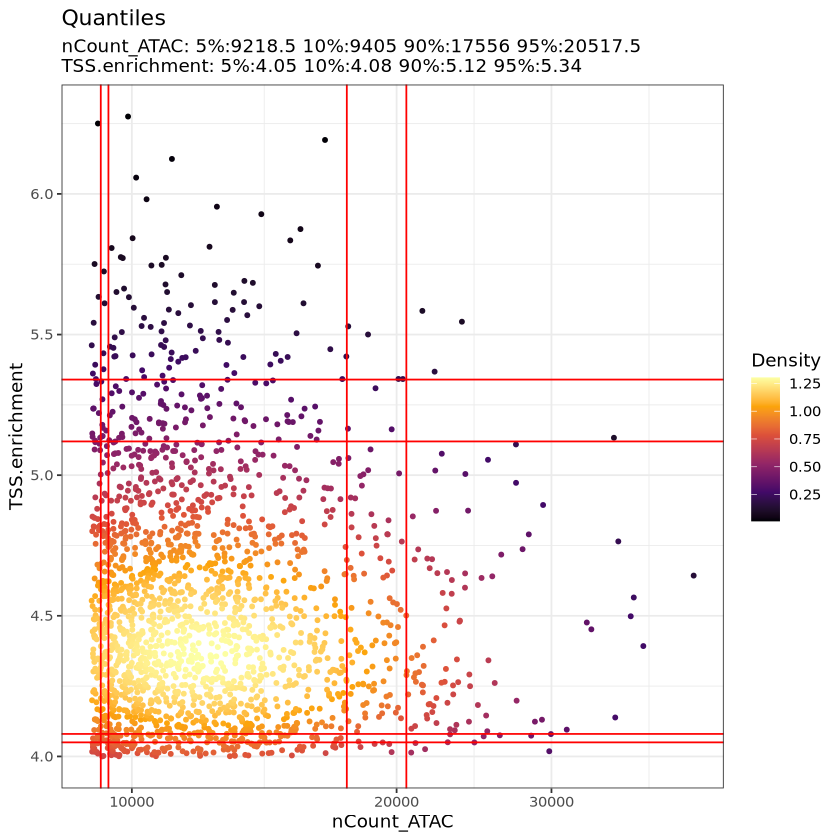

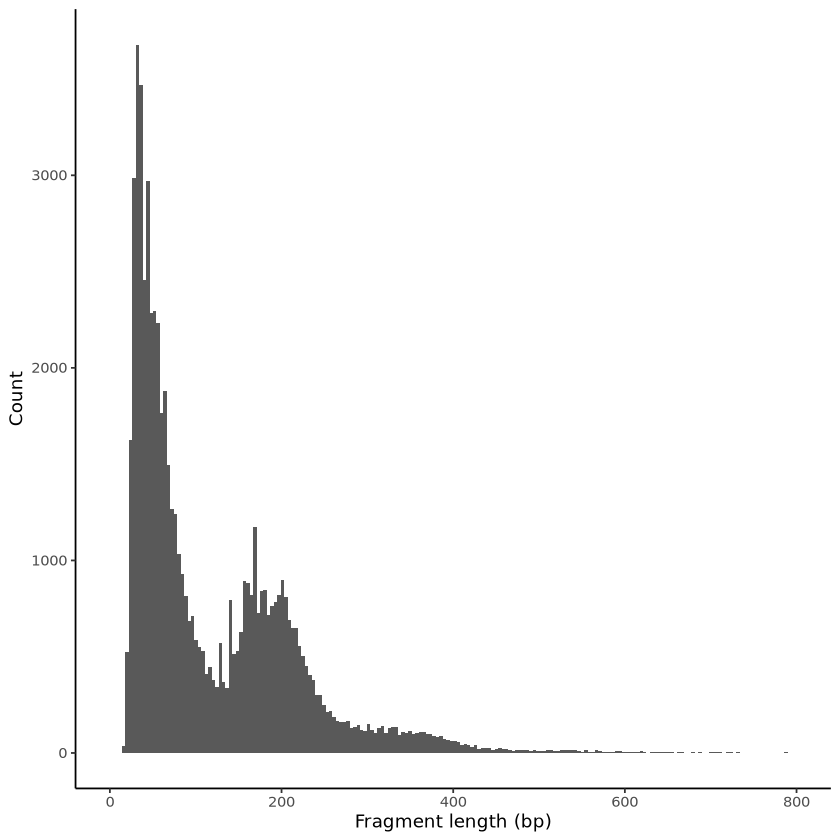

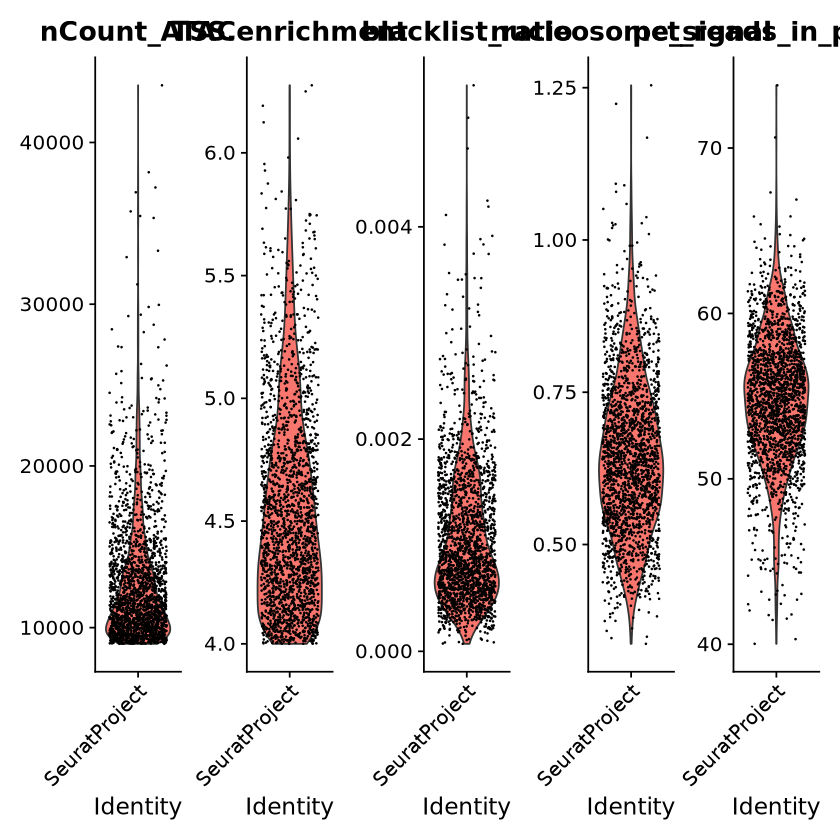

In [22]:

# add blacklist ratio
pbmc$blacklist_ratio <- FractionCountsInRegion(
  object = pbmc, 
  assay = 'ATAC',
  regions = blacklist_hg38_unified
)

DensityScatter(pbmc, x = 'nCount_ATAC', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)


pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')


VlnPlot(
  object = pbmc,
  features = c('nCount_ATAC', 'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 5
)

# Downstream Analysis

## Dimensionality Reduction
Q75
Save object to seurat object (Note for file name: q75/q90/...)

In [31]:
library(AnnotationHub)
library(biovizBase)
library(ensembldb)
# Load necessary libraries
library(Signac)
library(Seurat)
library(GenomicRanges)
library(dplyr)

In [24]:
# chosen_weeks = c(7, 9)
# gender = 'male'


# Save Seurat object to gender-specific filename
seurat_object_filepath <- paste0(
  "/group/tran3/gchahal/Garcia_et_all_FASTqs/",
  gender, "_seurat_obj_", paste(chosen_weeks, collapse = "_"), ".rds"
)
saveRDS(pbmc, file = seurat_object_filepath)
cat("Saved Seurat object to:", seurat_object_filepath, "\n")


seurat_obj <- readRDS(seurat_object_filepath)
seurat_obj


Saved Seurat object to: /group/tran3/gchahal/Garcia_et_all_FASTqs/male_seurat_obj_7_9.rds 


An object of class Seurat 
195095 features across 2031 samples within 1 assay 
Active assay: ATAC (195095 features, 0 variable features)
 2 layers present: counts, data

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, layer = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



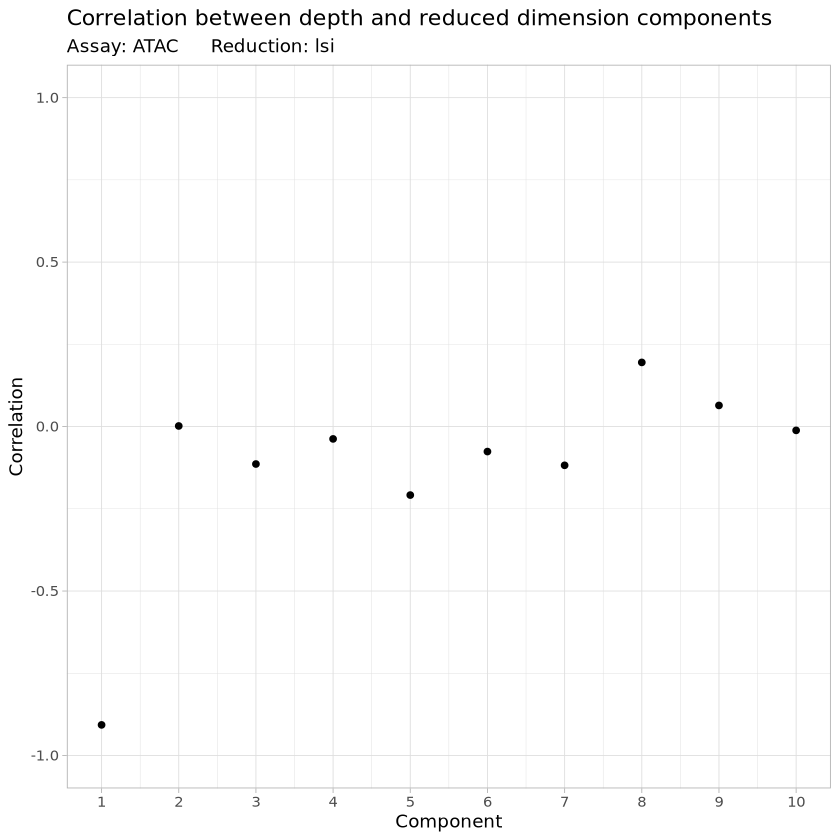

In [25]:

library(irlba)
library(Matrix)


seurat_obj <- RunTFIDF(seurat_obj)
seurat_obj <- FindTopFeatures(seurat_obj, min.cutoff = 'q75')
seurat_obj <- RunSVD(seurat_obj)

DepthCor(seurat_obj)

In [30]:
seurat_obj

An object of class Seurat 
195095 features across 2031 samples within 1 assay 
Active assay: ATAC (195095 features, 49084 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

In [27]:
# Show all metadata columns
colnames(seurat_obj@meta.data)
# Example if column is named 'celltype'
cell_types <- seurat_obj$cell_type

# See first few
table(seurat_obj$cell_type)



[1] "orig.ident"                       "nCount_ATAC"                     
 [3] "nFeature_ATAC"                    "total"                           
 [5] "duplicate"                        "chimeric"                        
 [7] "unmapped"                         "lowmapq"                         
 [9] "mitochondrial"                    "passed_filters"                  
[11] "cell_id"                          "is__cell_barcode"                
[13] "TSS_fragments"                    "DNase_sensitive_region_fragments"
[15] "enhancer_region_fragments"        "promoter_region_fragments"       
[17] "on_target_fragments"              "blacklist_region_fragments"      
[19] "peak_region_fragments"            "peak_region_cutsites"            
[21] "dataset"                          "cell_type"                       
[23] "nonprimary"                       "excluded_reason"                 
[25] "nucleosome_signal"                "nucleosome_percentile"           
[27] "TSS.enrichment"                   "TSS.percentile"                  
[29] "pct_reads_in_peaks"               "blacklist_ratio"                 
[31] "nucleosome_group"


          CoelEpi       Endothelial        Epithelial         Erythroid 
                8               109                59                12 
      FetalLeydig            Immune Mesenchymal_GATA2  Mesenchymal_LHX9 
               50                59               605               336 
          missing            Neural                PV           Sertoli 
              127               387                37               106 
       Supporting 
              136 

In [28]:
# don't run this code, irrelevant

# # doesn't really need this
# # main difference between this pipeline and Signac_merge_pipeline and Draft.ipynb


# # be aware of yourself when running this pipeline
# # Load variable features
# var_peaks <- VariableFeatures(seurat_obj)

# # Convert "chr15-75449339-75457073" to a data frame with chr, start, end
# library(dplyr)
# library(tidyr)

# peak_df <- data.frame(peak = var_peaks) %>%
#   separate(peak, into = c("chr", "start", "end"), sep = "-", convert = TRUE)

# head(peak_df)
# # Read the BED file, this is from Hieu's input
# testes_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/q75_week_7_9_testes_bed_file.bed"
# bed <- read.table(testes_bed_file, header = FALSE, sep = "\t", stringsAsFactors = FALSE)
# colnames(bed)[1:3] <- c("chr", "start", "end")

# # Inner join to get matching peaks
# filtered_bed <- inner_join(bed, peak_df, by = c("chr", "start", "end"))

# # View result
# head(filtered_bed)
# dim(filtered_bed)

# # # Optionally save it
# filtered_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/q75_filtered_week_7_9_testes_bed_file.bed"

# write.table(filtered_bed, filtered_bed_file,
#             sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

# # q0: 181870
# # q25: 137074
# # q50: 91051
# # q75: 45504
# # q90: 18190



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack


The following object is masked from 'package:S4Vectors':

    expand




,chr,start,end
,<chr>,<int>,<int>
1,chr15,75449905,75456945
2,chr19,54188099,54192205
3,chr13,110711398,110718071
4,chr6,32967291,32975446
5,chr5,138463217,138471526
6,chr6,108556957,108563162


,chr,start,end,V4
,<chr>,<int>,<int>,<chr>
1,chr1,100036901,100039466,testes_Neuro_Supp_Missing_MesLHX9_Sertoli_Eryth_Immune_Epi_FLeydig_Endo_CoelEpi_MesGATA2_PV
2,chr1,100132336,100133909,testes_Missing_Neuro_MesLHX9_Sertoli_Eryth_Endo_Immune_Epi_Supp_FLeydig_CoelEpi_MesGATA2_PV
3,chr1,10015423,10016347,testes_Missing_MesLHX9_Neuro_Supp_Immune_FLeydig_Sertoli_Epi_MesGATA2_Endo_PV
4,chr1,100188361,100189599,testes_Neuro_Missing_MesLHX9_Epi_Endo_Supp_MesGATA2_Immune_Eryth_Sertoli_FLeydig_PV_CoelEpi
5,chr1,100249002,100250475,testes_Neuro_Supp_Missing_MesLHX9_Endo_Epi_FLeydig_Sertoli_Immune_Eryth_CoelEpi_MesGATA2_PV
6,chr1,100265500,100267292,testes_MesLHX9_Neuro_Supp_Eryth_Missing_Endo_Epi_FLeydig_Immune_Sertoli_MesGATA2_PV_CoelEpi


[1] 49084     4

### UMAPs

14:58:56 UMAP embedding parameters a = 0.9922 b = 1.112

14:58:56 Read 2031 rows and found 29 numeric columns

14:58:56 Using Annoy for neighbor search, n_neighbors = 30

14:58:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:58:57 Writing NN index file to temp file /tmp/RtmpgpOGbK/file30ab0b449cb474

14:58:57 Searching Annoy index using 1 thread, search_k = 3000

14:58:57 Annoy recall = 100%

14:59:01 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:59:04 Initializing from normalized Laplacian + noise (using RSpectra)

14:59:04 Commencing optimization for 500 epochs, with 76368 positive edges

14:59:04 Using rng type: pcg

14:59:07 Optimization finished

Computing nearest neighbor graph

Computing SNN



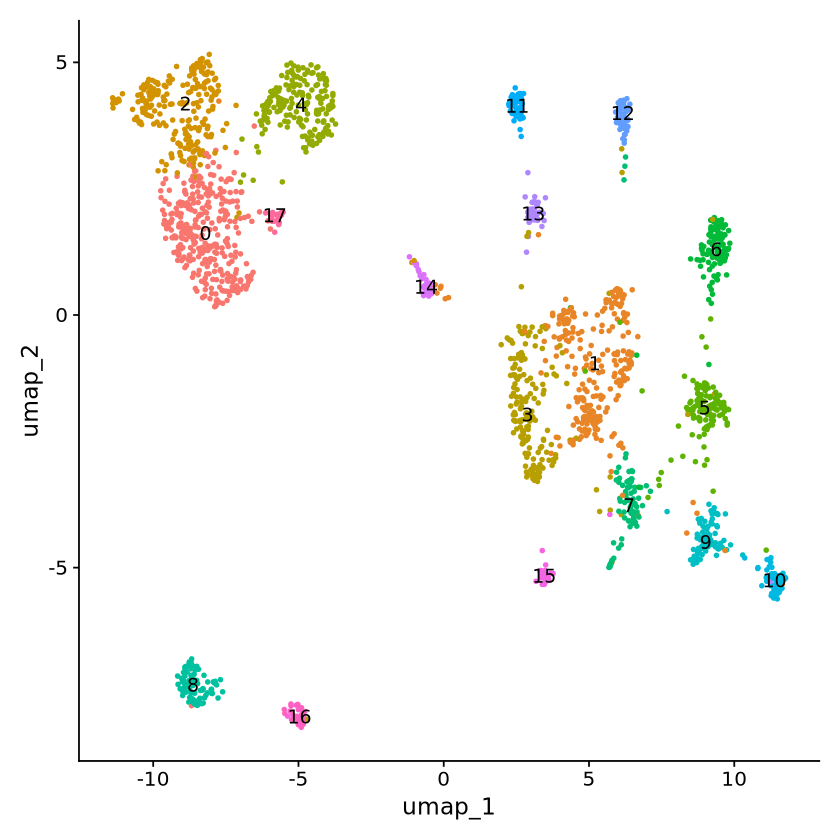

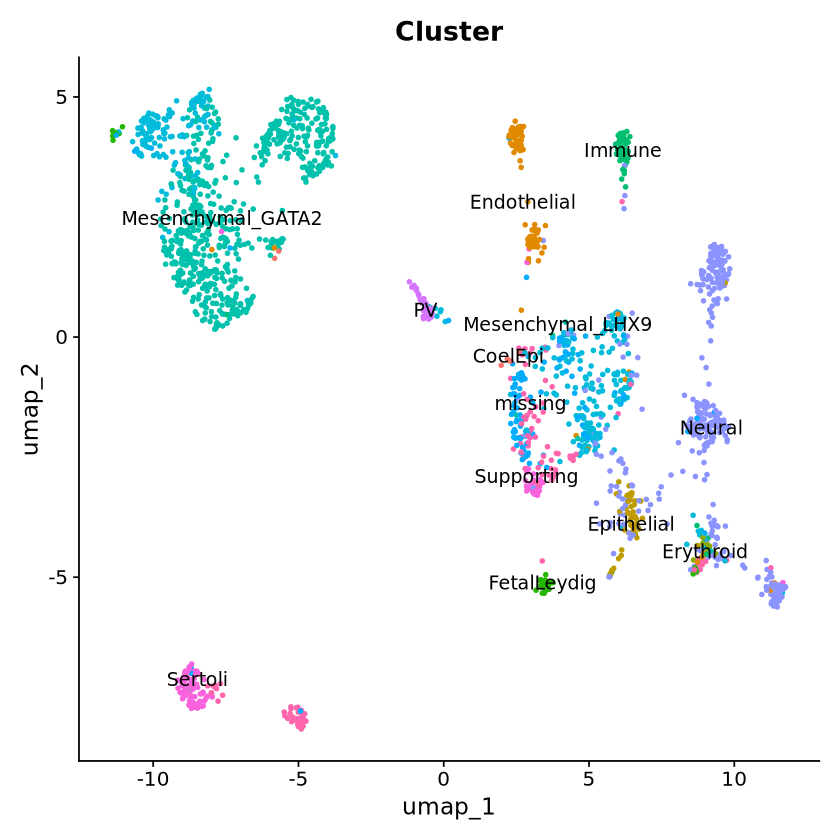

In [28]:
# UMAPs
seurat_obj <- RunUMAP(object = seurat_obj, reduction = 'lsi', dims = 2:30)
seurat_obj <- FindNeighbors(object = seurat_obj, reduction = 'lsi', dims = 2:30)
seurat_obj <- FindClusters(object = seurat_obj, verbose = FALSE, algorithm = 3)
DimPlot(object = seurat_obj, label = TRUE) + NoLegend()


library(ggplot2)

plot1 <- DimPlot(
  object = seurat_obj,
  group.by = 'cell_type',
  label = TRUE) + NoLegend() + ggtitle('Cluster')
plot1

## Integration with scRNA 

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Validating h5Seurat file

Initializing RNA with data

Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the SeuratDisk package.
  Please report the issue at
  <https://github.com/mojaveazure/seurat-disk/issues>."
Adding counts for RNA

Warning message:
"The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the SeuratDisk package.
  Please report the issue at
  <https://github.com/mojaveazure/seurat-disk/issues>."
Adding feature-level metadata for RNA

Adding reduction scVI

Adding cell embeddings for scVI

Adding miscellaneous information for scVI

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for

An object of class Seurat 
28820 features across 133811 samples within 1 assay 
Active assay: RNA (28820 features, 0 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: scVI, umap

An object of class Seurat 
28820 features across 213898 samples within 1 assay 
Active assay: RNA (28820 features, 0 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: scVI, umap

An object of class Seurat 
28820 features across 133811 samples within 1 assay 
Active assay: RNA (28820 features, 0 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: scVI, umap

Extracting gene coordinates

Warning message in SingleFeatureMatrix(fragment = fragments[[x]], features = features, :
"13 features are on seqnames not present in the fragment file. These will be removed."
Extracting reads overlapping genomic regions

Warning message in SingleFeatureMatrix(fragment = fragments[[x]], features = features, :
"13 features are on seqnames not present in the fragment file. These will be removed."
Extracting reads overlapping genomic regions

Warning message:
"The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9152 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Rasterizing points since number of points exceeds 100,000.
To disable

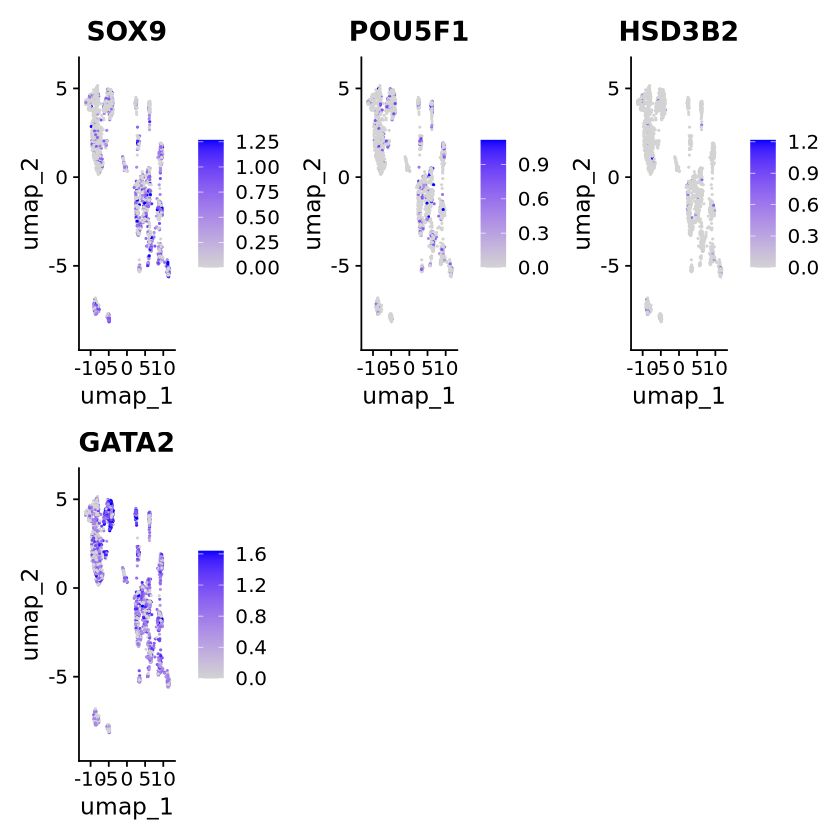

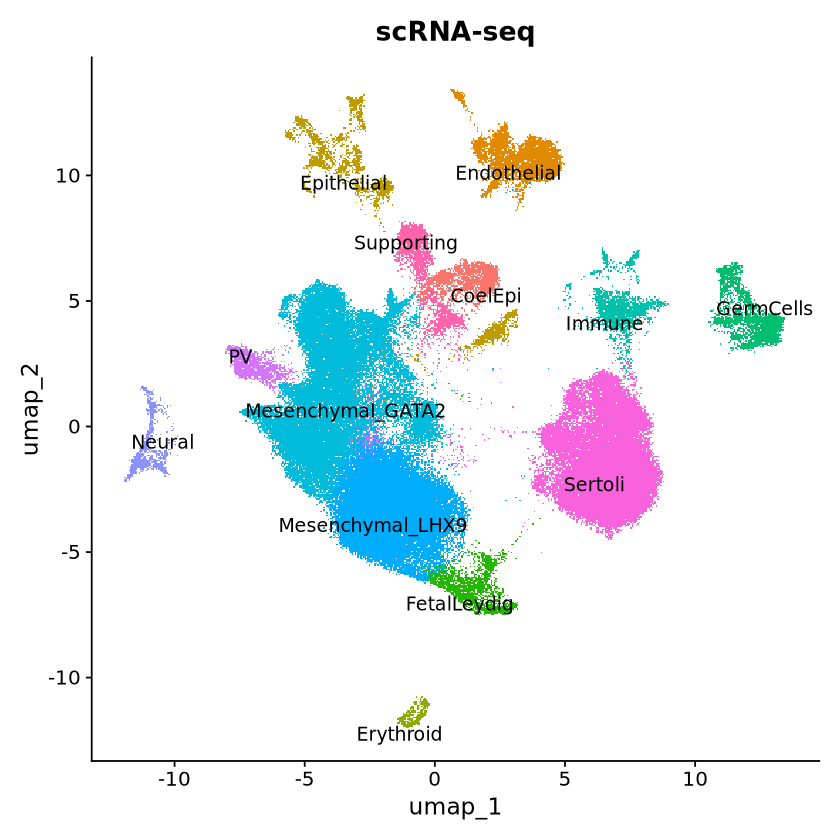

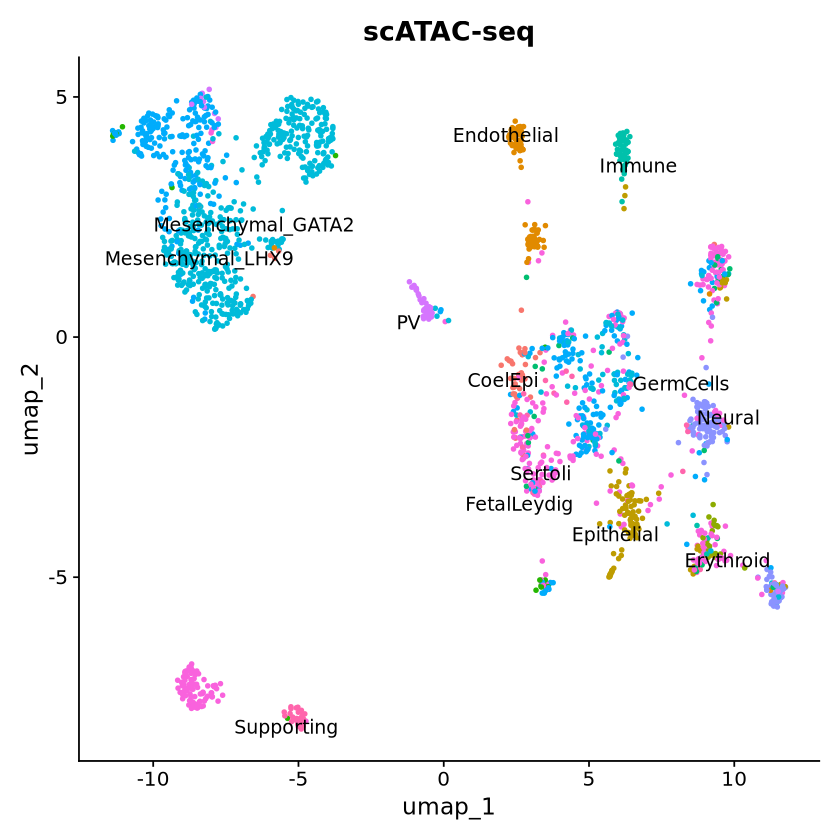

In [5]:
library(Signac)
library(Seurat)
library(GenomicRanges)
library(Matrix)
library(future)
library(AnnotationHub)
library(irlba)
library(SeuratDisk)



# Step 2: Load into Seurat
male_scrna <- LoadH5Seurat("human_main_male.h5seurat")
female_scrna <- LoadH5Seurat("human_main_female.h5seurat")

male_scrna
female_scrna
# decide on which scrna to run:
if (gender == "female") {
  scrna_obj <- female_scrna
  gene_lst <- c('FOXL2', 'POU5F1', 'GATA2' )
  
} else if (gender == "male") {
  scrna_obj <- male_scrna
  gene_lst <- c('SOX9', 'POU5F1', 'HSD3B2', 'GATA2')
} else {
  stop("Invalid gender. Must be 'male' or 'female'.")
}


scrna_obj

gene.activities <- GeneActivity(seurat_obj)


# add the gene activity matrix to the Seurat object as a new assay and normalize it
seurat_obj[['RNA']] <- CreateAssayObject(counts = gene.activities)
seurat_obj <- NormalizeData(
  object = seurat_obj,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(seurat_obj$nCount_RNA)
)


DefaultAssay(seurat_obj) <- 'RNA'

FeaturePlot(
  object = seurat_obj,
  features = gene_lst ,
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)


# add anchor
seurat_obj <- FindVariableFeatures(seurat_obj)
scrna_obj <- FindVariableFeatures(scrna_obj)


# find a list of marker genes
# Idents(scrna_obj) <- scrna_obj$lineage
# table(Idents(scrna_obj))  # Make sure the groups exist

# markers <- FindAllMarkers(scrna_obj)
# markers


transfer.anchors <- FindTransferAnchors(
  reference = scrna_obj,
  query = seurat_obj,
  reduction = 'cca'
)


predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = scrna_obj$lineage,
  weight.reduction = seurat_obj[['lsi']],
  dims = 2:30
)


seurat_obj <- AddMetaData(object = seurat_obj, metadata = predicted.labels)

plot1 <- DimPlot(
  object = scrna_obj,
  group.by = 'lineage',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

plot2 <- DimPlot(
  object = seurat_obj,
  group.by = 'predicted.id',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')

plot1 
plot2

In [13]:
predicted.labels

,predicted.id,prediction.score.Mesenchymal_LHX9,prediction.score.CoelEpi,prediction.score.Sertoli,prediction.score.Mesenchymal_GATA2,prediction.score.Supporting,prediction.score.Endothelial,prediction.score.PV,prediction.score.GermCells,prediction.score.Neural,prediction.score.FetalLeydig,prediction.score.Epithelial,prediction.score.Immune,prediction.score.Erythroid,prediction.score.max
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCA_GND8795927_AAACGAACAGGCAAGT-1,Mesenchymal_GATA2,0.32417284,0.00000000,0.13400234,0.431762953,0.022372849,0.00000000,0.00000000,0.06915921,0.00000000,0.018529799,0.000000000,0.0000000,0.0000000,0.4317630
FCA_GND8795927_AAACTCGAGCTGAAAT-1,Epithelial,0.02161319,0.03381497,0.08825739,0.074050781,0.000000000,0.00000000,0.00000000,0.06883219,0.00000000,0.000000000,0.713431480,0.0000000,0.0000000,0.7134315
FCA_GND8795927_AAACTCGCATTAACGC-1,Mesenchymal_GATA2,0.13968564,0.00000000,0.03826624,0.732305308,0.000000000,0.00000000,0.00000000,0.05045117,0.00000000,0.000000000,0.039291650,0.0000000,0.0000000,0.7323053
FCA_GND8795927_AAACTCGGTAGACACG-1,Sertoli,0.16688713,0.00000000,0.56009977,0.030586949,0.000000000,0.00000000,0.00000000,0.17500274,0.00000000,0.006675030,0.060748373,0.0000000,0.0000000,0.5600998
FCA_GND8795927_AAACTCGGTCACAGGA-1,Neural,0.08648482,0.00000000,0.17340271,0.081689381,0.011735479,0.00000000,0.00000000,0.00000000,0.64668761,0.000000000,0.000000000,0.0000000,0.0000000,0.6466876
FCA_GND8795927_AAACTCGGTGTCTACA-1,Epithelial,0.02692789,0.03971545,0.12203762,0.033449703,0.000000000,0.00000000,0.00000000,0.04474853,0.00000000,0.000000000,0.733120812,0.0000000,0.0000000,0.7331208
FCA_GND8795927_AAACTGCAGGCGTCCT-1,Sertoli,0.10203548,0.00000000,0.68429584,0.039805541,0.173863134,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.000000000,0.0000000,0.0000000,0.6842958
FCA_GND8795927_AAACTGCCAAGAAACT-1,Epithelial,0.03254448,0.01068171,0.25548344,0.020351647,0.000000000,0.00000000,0.00000000,0.05157886,0.00000000,0.220745249,0.408614608,0.0000000,0.0000000,0.4086146
FCA_GND8795927_AAACTGCCAATGAAAC-1,Sertoli,0.18038741,0.01226451,0.30802080,0.128969906,0.173394595,0.08133675,0.00000000,0.05380916,0.00000000,0.000000000,0.030506365,0.0313105,0.0000000,0.3080208


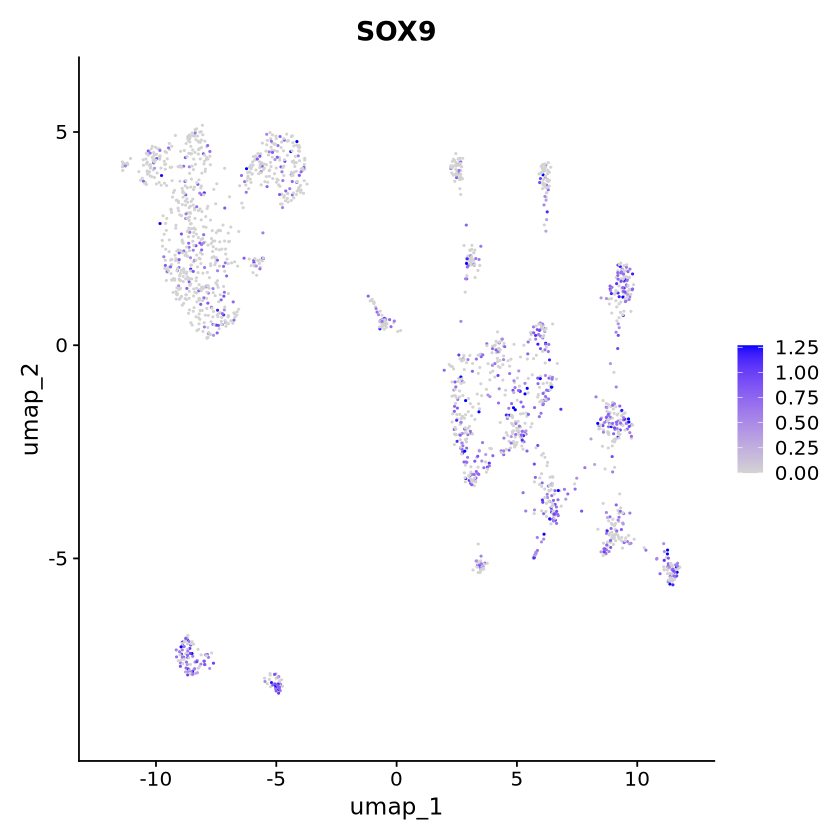

In [7]:
FeaturePlot(
  object = seurat_obj,
  features =  c('SOX9') ,
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 1
)

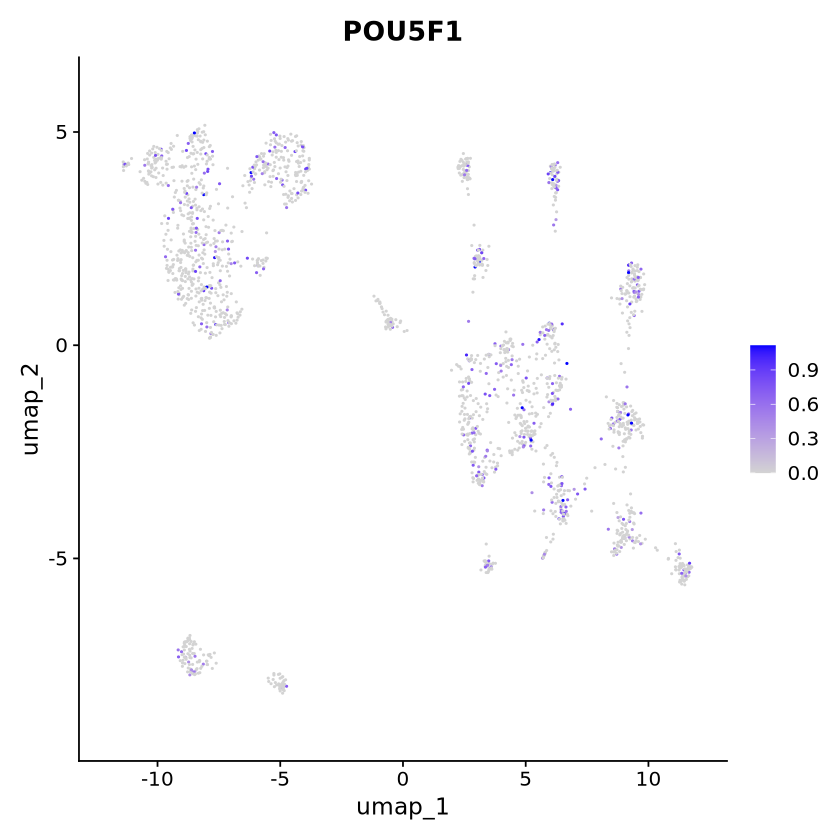

In [8]:

FeaturePlot(
  object = seurat_obj,
  features =  c('POU5F1') ,
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 1
)



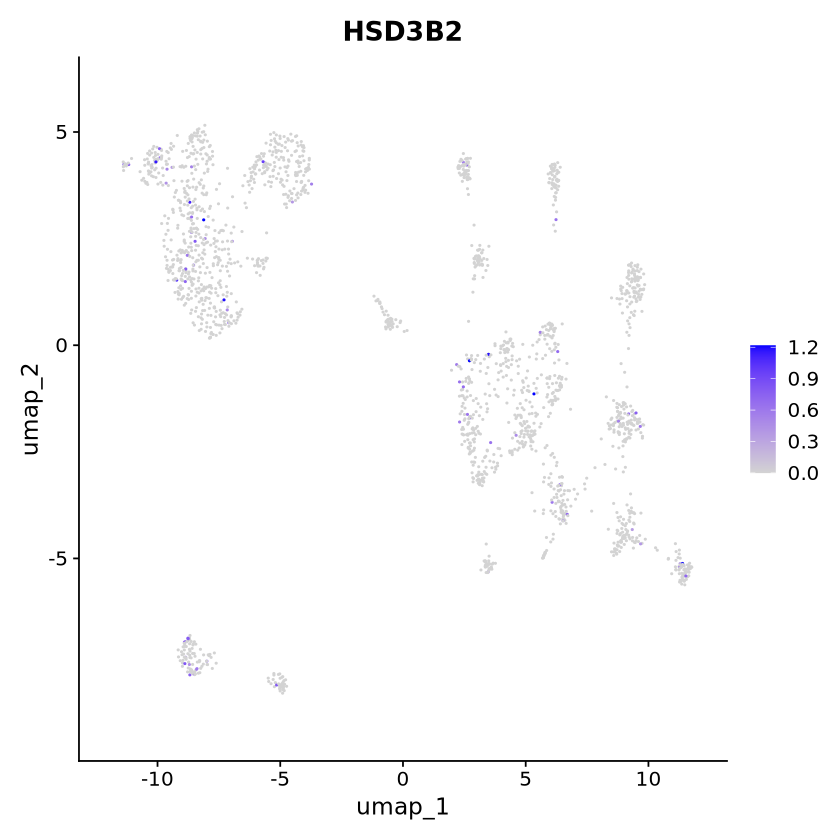

In [9]:
FeaturePlot(
  object = seurat_obj,
  features =  c('HSD3B2') ,
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 1
)

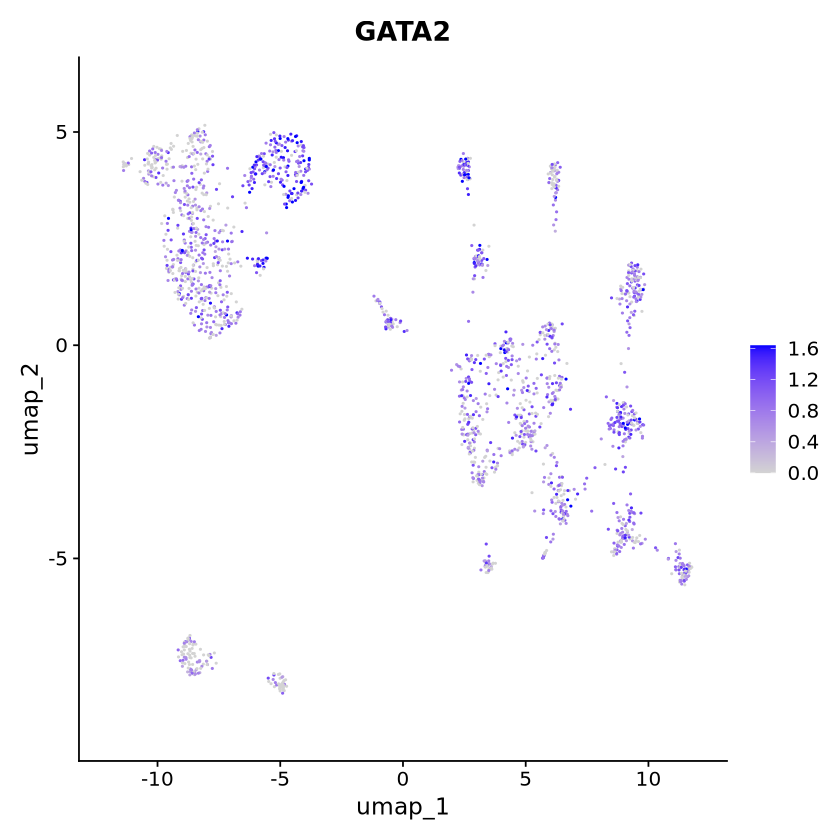

In [10]:
FeaturePlot(
  object = seurat_obj,
  features =  c('GATA2') ,
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 1
)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



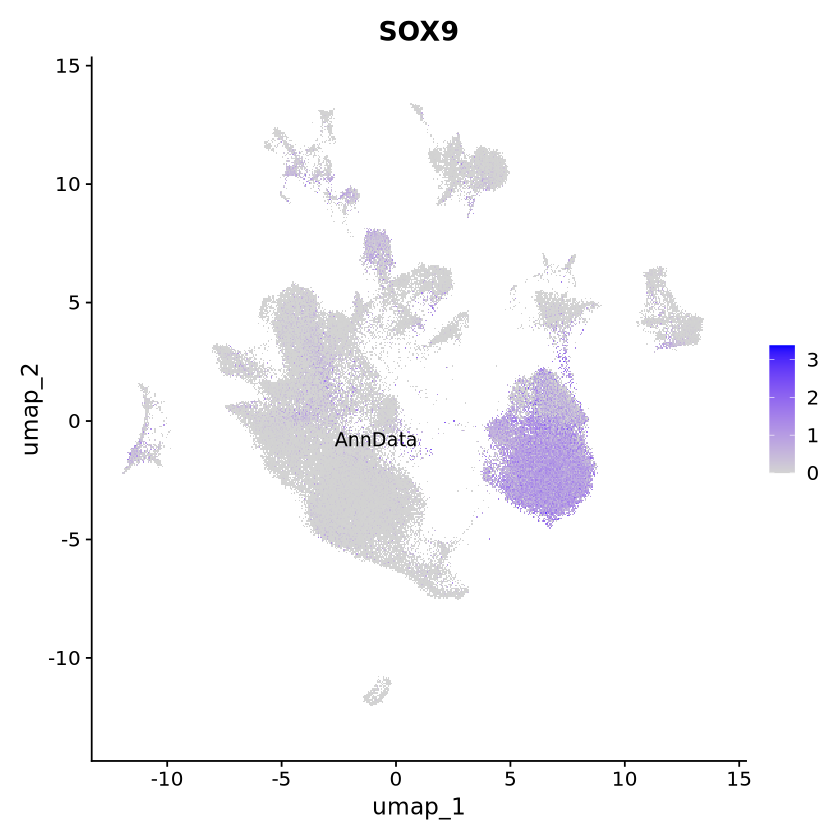

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



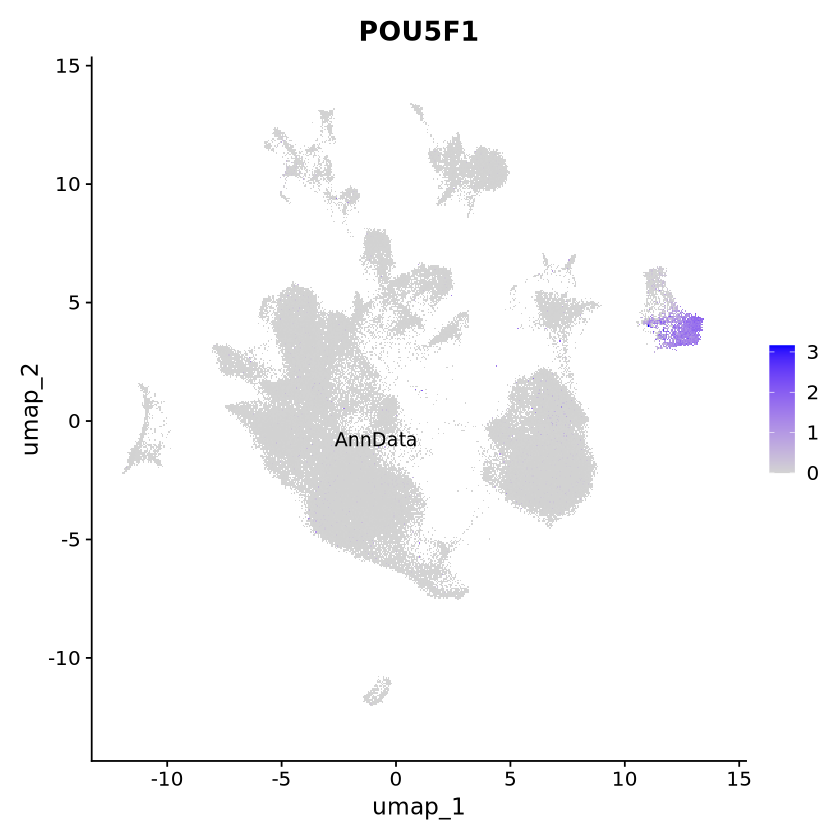

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



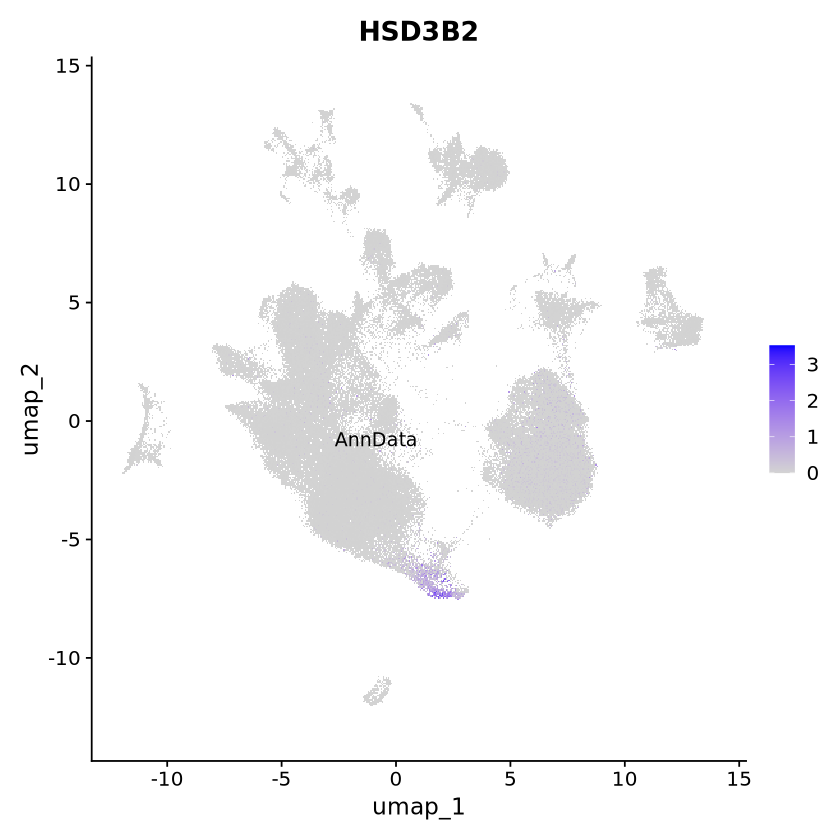

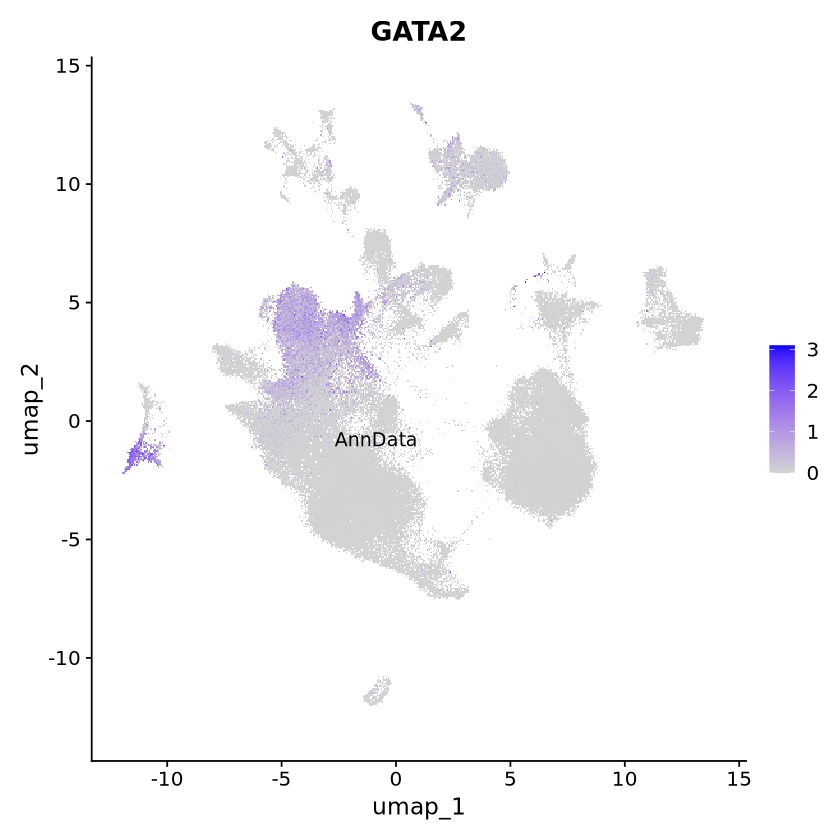

In [11]:
for (gene in gene_lst) {
  print(FeaturePlot(scrna_obj, features = gene, reduction = "umap", label = TRUE) + ggtitle(gene))
}


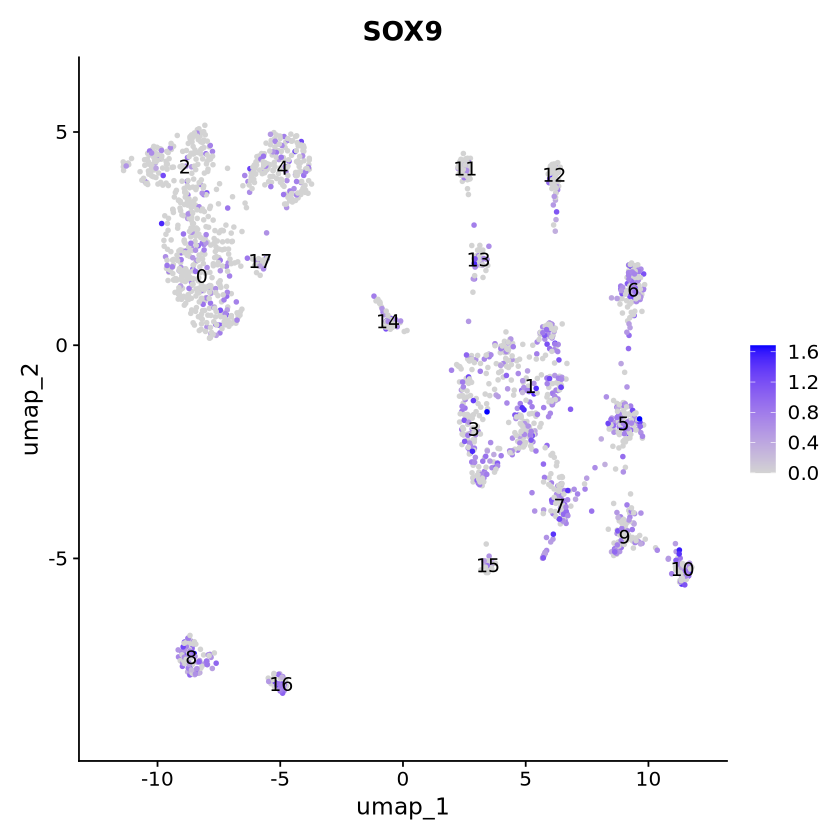

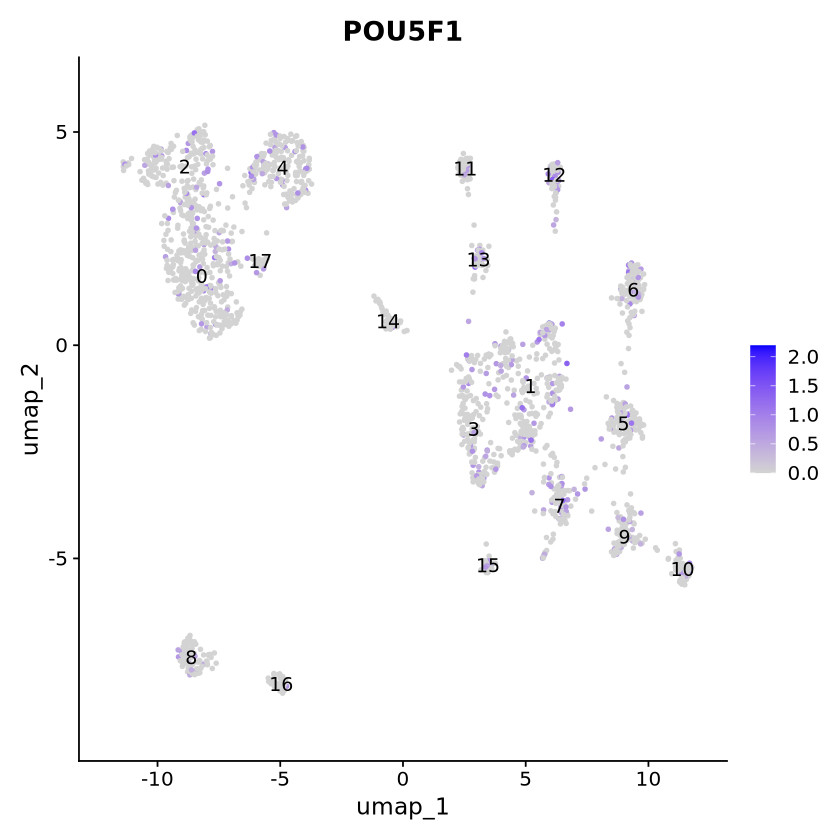

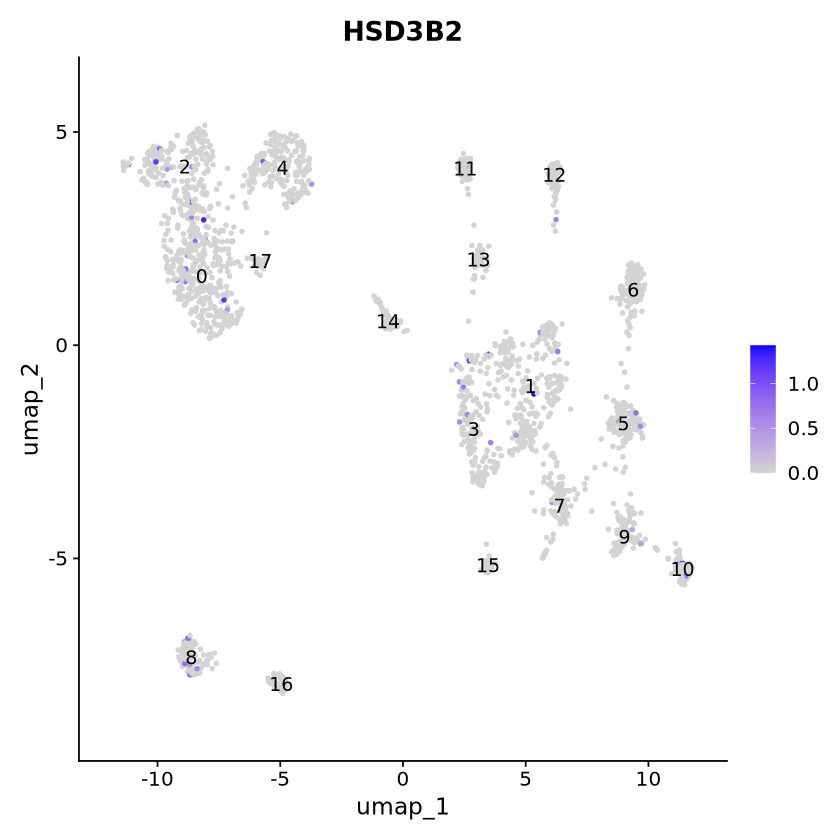

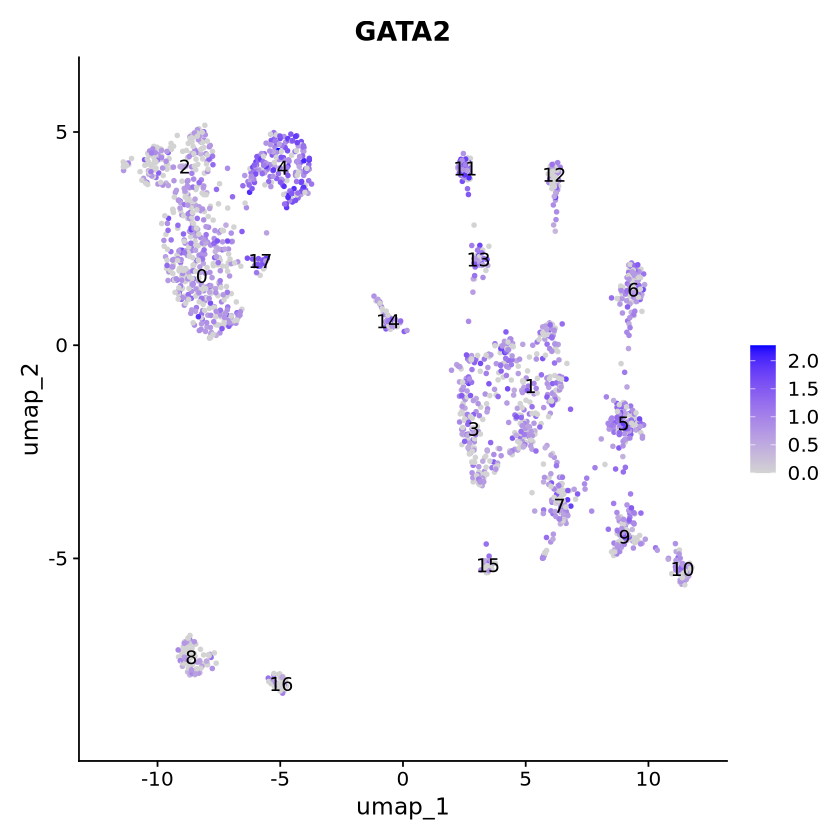

In [12]:
for (gene in gene_lst) {
  print(FeaturePlot(seurat_obj, features = gene, reduction = "umap", label = TRUE) + ggtitle(gene))
}


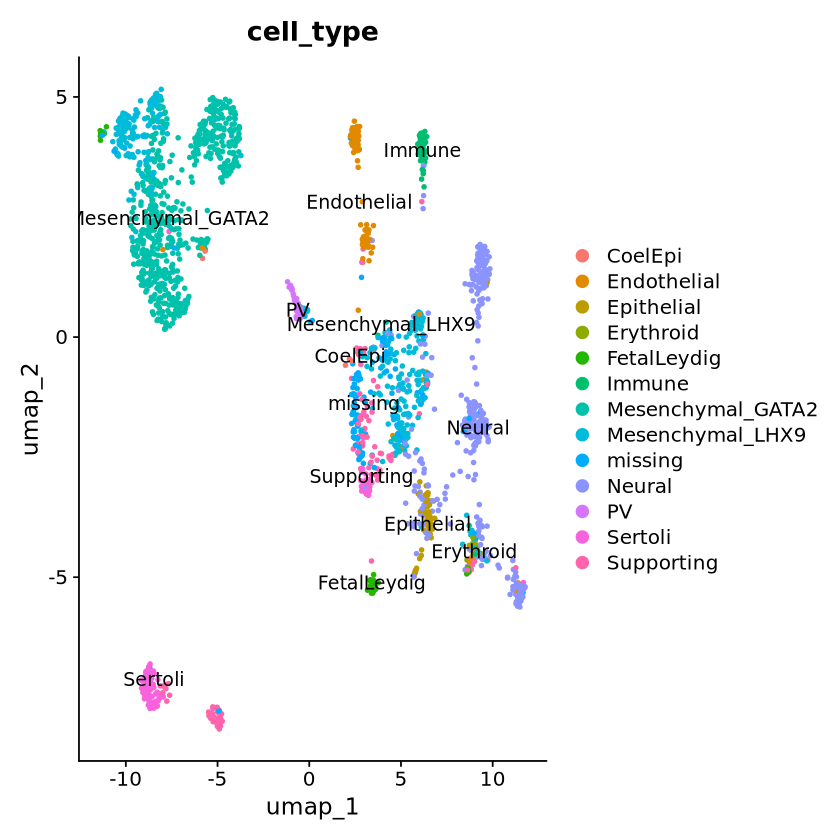

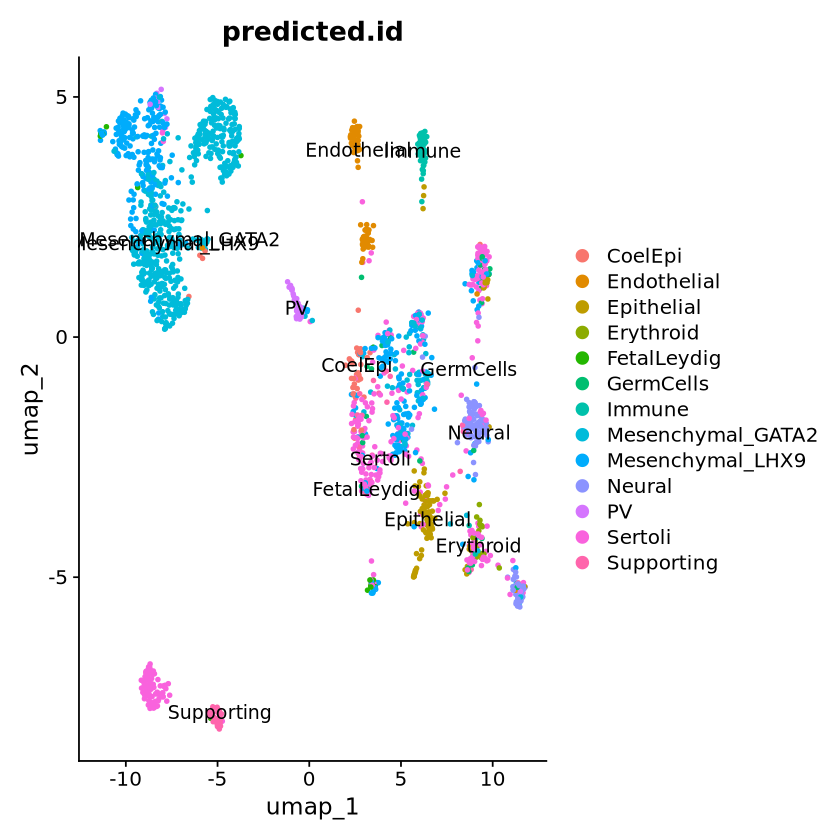

In [14]:
DimPlot(seurat_obj, reduction = "umap", group.by = "cell_type", label = TRUE)
DimPlot(seurat_obj, reduction = "umap", group.by = "predicted.id", label = TRUE)

In [ ]:
# # get the gene expression
# # for female
# # Export raw RNA counts
# write.csv(as.matrix(GetAssayData(female_scrna, assay = "RNA", slot = "counts")),
#           file = "rna_counts_raw.csv")

# # Export normalized RNA expression (log-normalized by default)
# write.csv(as.matrix(GetAssayData(female_scrna, assay = "RNA", slot = "data")),
#           file = "rna_expression_normalized.csv")


# # for male
# write.csv(as.matrix(GetAssayData(male_scrna, assay = "RNA", slot = "counts")),
#           file = "rna_counts_raw.csv")

# # Export normalized RNA expression (log-normalized by default)
# write.csv(as.matrix(GetAssayData(male_scrna, assay = "RNA", slot = "data")),
#           file = "rna_expression_normalized.csv")




In [ ]:
# # for female
# if (gender == "female") {
#   write.csv(as.matrix(GetAssayData(seurat_obj[["RNA"]], slot = "counts")),
#             file = "gene_activity_raw_female.csv")
#   write.csv(as.matrix(GetAssayData(seurat_obj[["RNA"]], slot = "data")),
#             file = "gene_activity_normalized_female.csv")
# } else if (gender == "male"){
#   write.csv(as.matrix(GetAssayData(seurat_obj[["RNA"]], slot = "counts")),
#             file = "gene_activity_raw_male.csv")
#   write.csv(as.matrix(GetAssayData(seurat_obj[["RNA"]], slot = "data")),
#             file = "gene_activity_normalized_male.csv")
#     }



## Hieu's CRE Pipeline bed file formatting

In [29]:
seurat_obj

An object of class Seurat 
195095 features across 2031 samples within 1 assay 
Active assay: ATAC (195095 features, 49084 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

### Scores for row-wise

In [32]:
# library(Matrix)
# library(dplyr)

# # 1. Extract data
# counts_matrix <- seurat_obj[["ATAC"]]@counts   # sparse matrix: features x cells
# cell_types <- seurat_obj@meta.data$cell_type
# names(cell_types) <- colnames(seurat_obj)      # map cell names to cell types

# # 2. Create a mapping from columns (cells) to their cell types
# cell_type_vec <- cell_types[colnames(counts_matrix)]

# # 3. For each feature, count nonzero entries per cell type
# feature_counts_by_type <- apply(counts_matrix, 1, function(x) {
#   active_cells <- which(x != 0)
#   active_cell_types <- cell_type_vec[active_cells]
#   tab <- table(active_cell_types)
#   return(tab)
# })

# # 4. Combine into data.frame
# # (transpose, fill NAs, and add feature names)
# df <- do.call(rbind, lapply(feature_counts_by_type, function(x) as.data.frame(as.list(x))))
# df[is.na(df)] <- 0

# # 5. Add feature name as row
# df$feature <- rownames(counts_matrix)
# df <- df[, c("feature", setdiff(colnames(df), "feature"))]

# # 6. Optional: Split feature into chr-start-end if needed
# df <- df %>%
#   tidyr::separate(feature, into = c("chr", "start", "end"), sep = "[-:]") %>%
#   relocate(chr, start, end)

# # View result
# head(df)
library(Matrix)
library(dplyr)
library(tidyr)

# 1. Extract data
counts_matrix <- seurat_obj[["ATAC"]]@counts   # sparse Matrix (dgCMatrix)
cell_types <- seurat_obj@meta.data$cell_type
names(cell_types) <- colnames(seurat_obj)

# 2. Map each column index to its cell type
cell_type_vec <- cell_types[colnames(counts_matrix)]

# 3. Use sparseMatrix to compute cell-type sums per feature
# Convert sparse matrix to triplet format
triplet <- summary(counts_matrix)  # gives i (row), j (col), x (value)

# Map j (cell index) to cell type
triplet$cell_type <- cell_type_vec[triplet$j]

# Make feature ID for output (e.g., rownames: chr-start-end)
feature_names <- rownames(counts_matrix)
triplet$feature <- feature_names[triplet$i]

# 4. Aggregate: count non-zero per feature per cell type
df <- triplet %>%
  dplyr::filter(x != 0) %>%
  dplyr::count(feature, cell_type, name = "count") %>%
  tidyr::pivot_wider(names_from = cell_type, values_from = count, values_fill = 0)

# 5. Optionally split feature into chr, start, end
df <- df %>%
  separate(feature, into = c("chr", "start", "end"), sep = "[-:]", convert = TRUE) %>%
  relocate(chr, start, end)

head(df)
dim(df)   

chr,start,end,Endothelial,Epithelial,Erythroid,FetalLeydig,Mesenchymal_GATA2,Mesenchymal_LHX9,Neural,PV,Sertoli,Supporting,missing,CoelEpi,Immune
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,100034378,100035198,3,3,1,1,23,5,5,1,3,3,6,0,0
chr1,100036901,100039466,47,30,5,15,229,119,171,15,42,47,45,1,30
chr1,100048200,100049167,0,1,0,0,0,2,5,0,8,3,1,0,2
chr1,100099307,100100350,0,0,0,0,2,2,2,2,4,3,1,0,1
chr1,100107518,100108376,0,0,0,0,0,0,1,0,2,1,0,0,0
chr1,100123523,100124324,0,0,0,0,1,0,1,0,2,0,1,0,0


[1] 195089     16

In [33]:
library(dplyr)
library(tidyr)

# Mapping from original to short forms
map_dict <- c(
  "Supporting"          = "Supp",
  "Mesenchymal_LHX9"    = "MesLHX9",
  "Epithelial"          = "Epi",
  "Endothelial"         = "Endo",
  "Neural"              = "Neuro",
  "missing"             = "Missing",
  "Erythroid"           = "Eryth",
  "Sertoli"             = "Sertoli",
  "Mesenchymal_GATA2"   = "MesGATA2",
  "FetalLeydig"         = "FLeydig",
  "PV"                  = "PV",
  "CoelEpi"             = "CoelEpi",
  "Immune"              = "Immune"
)

# Define the exact desired order
ordered_celltypes <- c("Supp", "MesLHX9", "Epi", "Endo", "Neuro", "Missing",
                       "Eryth", "Sertoli", "MesGATA2", "FLeydig", "PV")
df_long <- df %>%
  tidyr::pivot_longer(-c(chr, start, end), names_to = "cell_type", values_to = "count") %>%
  dplyr::filter(count > 0) %>%
  dplyr::mutate(short = map_dict[cell_type]) %>%
  dplyr::filter(!is.na(short)) %>%
  dplyr::mutate(tag = paste0(short, "_", count))

df_final <- df_long %>%
  dplyr::mutate(short = factor(short, levels = ordered_celltypes)) %>%
  dplyr::arrange(chr, start, end, short) %>%
  dplyr::group_by(chr, start, end) %>%
  dplyr::summarise(celltype_string = paste(tag, collapse = "_"), .groups = "drop")

df_final %>% dplyr::filter(start == 100036901)

head(df)
head(df_final)



chr,start,end,celltype_string
<chr>,<int>,<int>,<chr>
chr1,100036901,100039466,Supp_47_MesLHX9_119_Epi_30_Endo_47_Neuro_171_Missing_45_Eryth_5_Sertoli_42_MesGATA2_229_FLeydig_15_PV_15_CoelEpi_1_Immune_30


chr,start,end,Endothelial,Epithelial,Erythroid,FetalLeydig,Mesenchymal_GATA2,Mesenchymal_LHX9,Neural,PV,Sertoli,Supporting,missing,CoelEpi,Immune
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1,100034378,100035198,3,3,1,1,23,5,5,1,3,3,6,0,0
chr1,100036901,100039466,47,30,5,15,229,119,171,15,42,47,45,1,30
chr1,100048200,100049167,0,1,0,0,0,2,5,0,8,3,1,0,2
chr1,100099307,100100350,0,0,0,0,2,2,2,2,4,3,1,0,1
chr1,100107518,100108376,0,0,0,0,0,0,1,0,2,1,0,0,0
chr1,100123523,100124324,0,0,0,0,1,0,1,0,2,0,1,0,0


chr,start,end,celltype_string
<chr>,<int>,<int>,<chr>
chr1,180609,181665,Supp_8_MesLHX9_15_Endo_2_Neuro_14_Missing_9_Sertoli_3_MesGATA2_12_FLeydig_1
chr1,191293,191699,MesLHX9_1_Endo_2_Neuro_7_Sertoli_2_PV_1_Immune_1
chr1,267583,268554,Supp_1_Endo_1_Neuro_6_Missing_1_Sertoli_2_MesGATA2_2_CoelEpi_1
chr1,585754,586651,Supp_1_MesLHX9_2_Endo_1_Neuro_4_Sertoli_2_MesGATA2_5_FLeydig_1_Immune_1
chr1,629497,630393,Supp_26_MesLHX9_74_Epi_15_Endo_35_Neuro_16_Missing_13_Eryth_1_Sertoli_42_MesGATA2_285_FLeydig_14_PV_18_CoelEpi_4_Immune_12
chr1,633517,634477,Supp_49_MesLHX9_158_Epi_16_Endo_57_Neuro_48_Missing_24_Sertoli_69_MesGATA2_552_FLeydig_19_PV_34_CoelEpi_7_Immune_20


In [34]:
library(dplyr)

aggregated <- df_final %>%
  rename(aggregated_cell_type = celltype_string) 

head(aggregated)
dim(aggregated)

chr,start,end,aggregated_cell_type
<chr>,<int>,<int>,<chr>
chr1,180609,181665,Supp_8_MesLHX9_15_Endo_2_Neuro_14_Missing_9_Sertoli_3_MesGATA2_12_FLeydig_1
chr1,191293,191699,MesLHX9_1_Endo_2_Neuro_7_Sertoli_2_PV_1_Immune_1
chr1,267583,268554,Supp_1_Endo_1_Neuro_6_Missing_1_Sertoli_2_MesGATA2_2_CoelEpi_1
chr1,585754,586651,Supp_1_MesLHX9_2_Endo_1_Neuro_4_Sertoli_2_MesGATA2_5_FLeydig_1_Immune_1
chr1,629497,630393,Supp_26_MesLHX9_74_Epi_15_Endo_35_Neuro_16_Missing_13_Eryth_1_Sertoli_42_MesGATA2_285_FLeydig_14_PV_18_CoelEpi_4_Immune_12
chr1,633517,634477,Supp_49_MesLHX9_158_Epi_16_Endo_57_Neuro_48_Missing_24_Sertoli_69_MesGATA2_552_FLeydig_19_PV_34_CoelEpi_7_Immune_20


[1] 195089      4

In [35]:
head(aggregated)

chr,start,end,aggregated_cell_type
<chr>,<int>,<int>,<chr>
chr1,180609,181665,Supp_8_MesLHX9_15_Endo_2_Neuro_14_Missing_9_Sertoli_3_MesGATA2_12_FLeydig_1
chr1,191293,191699,MesLHX9_1_Endo_2_Neuro_7_Sertoli_2_PV_1_Immune_1
chr1,267583,268554,Supp_1_Endo_1_Neuro_6_Missing_1_Sertoli_2_MesGATA2_2_CoelEpi_1
chr1,585754,586651,Supp_1_MesLHX9_2_Endo_1_Neuro_4_Sertoli_2_MesGATA2_5_FLeydig_1_Immune_1
chr1,629497,630393,Supp_26_MesLHX9_74_Epi_15_Endo_35_Neuro_16_Missing_13_Eryth_1_Sertoli_42_MesGATA2_285_FLeydig_14_PV_18_CoelEpi_4_Immune_12
chr1,633517,634477,Supp_49_MesLHX9_158_Epi_16_Endo_57_Neuro_48_Missing_24_Sertoli_69_MesGATA2_552_FLeydig_19_PV_34_CoelEpi_7_Immune_20


In [36]:
# testes_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/scores_q75_week_7_9_testes_bed_file.bed"
library(glue)
weeks_str <- paste(chosen_weeks, collapse = "_")
file_name <- glue("scores_q75_week_{weeks_str}_{gender}_bed_file.bed")
dir_path <- "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas"
file_path <- file.path(dir_path, file_name)

testes_bed_file <- file_path
print(testes_bed_file)
write.table(
  aggregated,
  file = testes_bed_file,
  sep = "\t",
  quote = FALSE,
  row.names = FALSE,
  col.names = FALSE
)



[1] "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/scores_q75_week_7_9_male_bed_file.bed"


In [37]:


# doesn't really need this
# main difference between this pipeline and Signac_merge_pipeline and Draft.ipynb


# be aware of yourself when running this pipeline
# Load variable features
var_peaks <- VariableFeatures(seurat_obj)

# Convert "chr15-75449339-75457073" to a data frame with chr, start, end
library(dplyr)
library(tidyr)

peak_df <- data.frame(peak = var_peaks) %>%
  separate(peak, into = c("chr", "start", "end"), sep = "-", convert = TRUE)

head(peak_df)
# Read the BED file, this is from Hieu's input
# testes_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/scores_q75_week_7_9_testes_bed_file.bed"
testes_bed_file <- file_path
bed <- read.table(testes_bed_file, header = FALSE, sep = "\t", stringsAsFactors = FALSE)
colnames(bed)[1:3] <- c("chr", "start", "end")

# Inner join to get matching peaks
filtered_bed <- inner_join(bed, peak_df, by = c("chr", "start", "end"))

# View result
head(filtered_bed)
dim(filtered_bed)

# # Optionally save it
# filtered_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/scores_q75_filtered_week_7_9_testes_bed_file.bed"

weeks_str <- paste(chosen_weeks, collapse = "_")
file_name <- glue("scores_q75_filtered_week_{weeks_str}_{gender}_bed_file.bed")
dir_path <- "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas"
file_path <- file.path(dir_path, file_name)
filtered_bed_file <- file_path

write.table(filtered_bed, filtered_bed_file,
            sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

# q0: 181870
# q25: 137074
# q50: 91051
# q75: 45504 - 49084
# q90: 18190


,chr,start,end
,<chr>,<int>,<int>
1,chr15,75449905,75456945
2,chr19,54188099,54192205
3,chr13,110711398,110718071
4,chr6,32967291,32975446
5,chr5,138463217,138471526
6,chr6,108556957,108563162


,chr,start,end,V4
,<chr>,<int>,<int>,<chr>
1,chr1,629497,630393,Supp_26_MesLHX9_74_Epi_15_Endo_35_Neuro_16_Missing_13_Eryth_1_Sertoli_42_MesGATA2_285_FLeydig_14_PV_18_CoelEpi_4_Immune_12
2,chr1,633517,634477,Supp_49_MesLHX9_158_Epi_16_Endo_57_Neuro_48_Missing_24_Sertoli_69_MesGATA2_552_FLeydig_19_PV_34_CoelEpi_7_Immune_20
3,chr1,778195,779413,Supp_35_MesLHX9_88_Epi_21_Endo_28_Neuro_141_Missing_41_Eryth_3_Sertoli_33_MesGATA2_136_FLeydig_13_PV_15_CoelEpi_3_Immune_20
4,chr1,826636,827932,Supp_21_MesLHX9_40_Epi_6_Endo_24_Neuro_52_Missing_25_Eryth_2_Sertoli_29_MesGATA2_65_FLeydig_10_PV_10_CoelEpi_2_Immune_15
5,chr1,869518,870408,Supp_18_MesLHX9_23_Epi_8_Endo_14_Neuro_54_Missing_12_Eryth_1_Sertoli_17_MesGATA2_24_FLeydig_1_PV_3_CoelEpi_1_Immune_7
6,chr1,904240,908604,Supp_41_MesLHX9_68_Epi_20_Endo_17_Neuro_110_Missing_26_Eryth_3_Sertoli_39_MesGATA2_106_FLeydig_11_PV_21_CoelEpi_3_Immune_19


[1] 49084     4

### Peak files for working with Hieu's input

In [38]:
seurat_obj

An object of class Seurat 
195095 features across 2031 samples within 1 assay 
Active assay: ATAC (195095 features, 49084 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

In [39]:
# normalize --> threshold (0.95 e.g)

# for each combination of 

# for each cell type: how many cell type combination does this cell type dominate

cell_types <- seurat_obj@meta.data$cell_type
names(cell_types) <- colnames(seurat_obj)
counts_matrix <- seurat_obj[["ATAC"]]@counts


# Convert sparse matrix to triplet format
counts_triplet <- summary(counts_matrix)  # data.frame with i, j, x

# Map column indices (cells) to cell types
cell_names <- colnames(counts_matrix)
counts_triplet$cell <- cell_names[counts_triplet$j]
counts_triplet$cell_type <- cell_types[counts_triplet$cell]

# Map row indices to peak names
peak_names <- rownames(counts_matrix)
counts_triplet$peak <- peak_names[counts_triplet$i]

# Aggregate: list of cell types per peak
library(dplyr)

aggregated <- counts_triplet %>%
  group_by(peak) %>%
  summarise(aggregated_cell_type = paste(unique(cell_type), collapse = ",")) %>%
  as.data.frame()


In [40]:
head(aggregated)

,peak,aggregated_cell_type
,<chr>,<chr>
1,chr1-100034378-100035198,"Supporting,Mesenchymal_LHX9,Epithelial,Endothelial,Neural,missing,Erythroid,Sertoli,Mesenchymal_GATA2,FetalLeydig,PV"
2,chr1-100036901-100039466,"Neural,Supporting,missing,Mesenchymal_LHX9,Sertoli,Erythroid,Immune,Epithelial,FetalLeydig,Endothelial,CoelEpi,Mesenchymal_GATA2,PV"
3,chr1-100048200-100049167,"Epithelial,Neural,missing,Mesenchymal_LHX9,Immune,Supporting,Sertoli"
4,chr1-100099307-100100350,"missing,Neural,Mesenchymal_LHX9,Immune,Sertoli,Mesenchymal_GATA2,Supporting,PV"
5,chr1-100107518-100108376,"Neural,Supporting,Sertoli"
6,chr1-100123523-100124324,"Neural,missing,Sertoli,Mesenchymal_GATA2"


In [41]:
# Step 1: Split peak into chr, start, end
peak_split <- do.call(rbind, strsplit(aggregated$peak, "-"))
aggregated$chr <- peak_split[,1]
aggregated$start <- as.integer(peak_split[,2])
aggregated$end <- as.integer(peak_split[,3])



# Step 3: Map to short form
map_dict <- c(
  "Mesenchymal_LHX9"    = "MesLHX9",
  "Mesenchymal_GATA2"   = "MesGATA2",
  "Supporting"          = "Supp",
  "preGranulosa"        = "preGran",
  "missing"             = "Missing",
  "Endothelial"         = "Endo",
  "PV"                  = "PV",
  "CoelEpi"             = "CoelEpi",
  "Epithelial"          = "Epi",
  "Neural"              = "Neuro",
  "Immune"              = "Immune",
  "GermCells"           = "Germ",
  "SMCs"                = "SMC",
  "Sertoli"             = "Sertoli",
  "Erythroid"           = "Eryth",
  "FetalLeydig"         = "FLeydig"
)


# Function to map all comma-separated values
shorten_labels <- function(s) {
  cell_types <- unlist(strsplit(s, ","))
  mapped <- map_dict[cell_types]
  final_label <- paste(c("testes", mapped), collapse = "_")
  return(final_label)
}

aggregated$aggregated_cell_type <- sapply(aggregated$aggregated_cell_type, shorten_labels)




# Final dataframe
aggregated <- aggregated[, c("chr", "start", "end", "aggregated_cell_type")]
names(aggregated)[names(aggregated) == "aggregated_cell_type"] <- "cell_type"
head(aggregated)
dim(aggregated)
# chr, start, end, tissue, cell_type (_):  E.g: ovary_granulosa_coelepi

,chr,start,end,cell_type
,<chr>,<int>,<int>,<chr>
1,chr1,100034378,100035198,testes_Supp_MesLHX9_Epi_Endo_Neuro_Missing_Eryth_Sertoli_MesGATA2_FLeydig_PV
2,chr1,100036901,100039466,testes_Neuro_Supp_Missing_MesLHX9_Sertoli_Eryth_Immune_Epi_FLeydig_Endo_CoelEpi_MesGATA2_PV
3,chr1,100048200,100049167,testes_Epi_Neuro_Missing_MesLHX9_Immune_Supp_Sertoli
4,chr1,100099307,100100350,testes_Missing_Neuro_MesLHX9_Immune_Sertoli_MesGATA2_Supp_PV
5,chr1,100107518,100108376,testes_Neuro_Supp_Sertoli
6,chr1,100123523,100124324,testes_Neuro_Missing_Sertoli_MesGATA2


[1] 195089      4

In [42]:
# testes_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/q75_week_7_9_testes_bed_file.bed"
library(glue)
weeks_str <- paste(chosen_weeks, collapse = "_")
file_name <- glue("q75_week_{weeks_str}_{gender}_bed_file.bed")
dir_path <- "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas"
file_path <- file.path(dir_path, file_name)

testes_bed_file <- file_path
print(testes_bed_file)

write.table(
  aggregated,
  file = testes_bed_file,
  sep = "\t",
  quote = FALSE,
  row.names = FALSE,
  col.names = FALSE
)



[1] "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/q75_week_7_9_male_bed_file.bed"


In [43]:


# doesn't really need this
# main difference between this pipeline and Signac_merge_pipeline and Draft.ipynb


# be aware of yourself when running this pipeline
# Load variable features
var_peaks <- VariableFeatures(seurat_obj)

# Convert "chr15-75449339-75457073" to a data frame with chr, start, end
library(dplyr)
library(tidyr)

peak_df <- data.frame(peak = var_peaks) %>%
  separate(peak, into = c("chr", "start", "end"), sep = "-", convert = TRUE)

head(peak_df)
# Read the BED file, this is from Hieu's input
# testes_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/scores_q75_week_7_9_testes_bed_file.bed"
testes_bed_file <- file_path
bed <- read.table(testes_bed_file, header = FALSE, sep = "\t", stringsAsFactors = FALSE)
colnames(bed)[1:3] <- c("chr", "start", "end")

# Inner join to get matching peaks
filtered_bed <- inner_join(bed, peak_df, by = c("chr", "start", "end"))

# View result
head(filtered_bed)
dim(filtered_bed)



,chr,start,end
,<chr>,<int>,<int>
1,chr15,75449905,75456945
2,chr19,54188099,54192205
3,chr13,110711398,110718071
4,chr6,32967291,32975446
5,chr5,138463217,138471526
6,chr6,108556957,108563162


,chr,start,end,V4
,<chr>,<int>,<int>,<chr>
1,chr1,100036901,100039466,testes_Neuro_Supp_Missing_MesLHX9_Sertoli_Eryth_Immune_Epi_FLeydig_Endo_CoelEpi_MesGATA2_PV
2,chr1,100132336,100133909,testes_Missing_Neuro_MesLHX9_Sertoli_Eryth_Endo_Immune_Epi_Supp_FLeydig_CoelEpi_MesGATA2_PV
3,chr1,10015423,10016347,testes_Missing_MesLHX9_Neuro_Supp_Immune_FLeydig_Sertoli_Epi_MesGATA2_Endo_PV
4,chr1,100188361,100189599,testes_Neuro_Missing_MesLHX9_Epi_Endo_Supp_MesGATA2_Immune_Eryth_Sertoli_FLeydig_PV_CoelEpi
5,chr1,100249002,100250475,testes_Neuro_Supp_Missing_MesLHX9_Endo_Epi_FLeydig_Sertoli_Immune_Eryth_CoelEpi_MesGATA2_PV
6,chr1,100265500,100267292,testes_MesLHX9_Neuro_Supp_Eryth_Missing_Endo_Epi_FLeydig_Immune_Sertoli_MesGATA2_PV_CoelEpi


[1] 49084     4

In [44]:

# # Optionally save it
# filtered_bed_file = "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas/scores_q75_filtered_week_7_9_testes_bed_file.bed"

weeks_str <- paste(chosen_weeks, collapse = "_")
file_name <- glue("q75_filtered_week_{weeks_str}_{gender}_bed_file.bed")
dir_path <- "/group/tran3/gchahal/other_tissues/CardiacNetworkComponentPredictor/Duy_CardiacNetworkComponentPredictor/data/scATAc_data_other_Domke_cellatlas"
file_path <- file.path(dir_path, file_name)
filtered_bed_file <- file_path

write.table(filtered_bed, filtered_bed_file,
            sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

# q0: 181870
# q25: 137074
# q50: 91051
# q75: 45504 - 49084
# q90: 18190